In [ ]:
import functools
import warnings


import torch
import numpy as np
import normflows as nf

from torch import nn
from matplotlib import pyplot as plt
import scipy.stats

from tqdm import tqdm

from matplotlib import rc
from mpl_toolkits.mplot3d import Axes3D

warnings.filterwarnings("ignore")


In [3]:
# Move model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')

## Define Model

In [4]:
def get_model():
    torch.manual_seed(0)

    # Define 2D Gaussian base distribution
    base = nf.distributions.base.DiagGaussian(2)

    # Define list of flows
    num_layers = 5
    flows = []
    for i in range(num_layers):
        # Neural network with two hidden layers having 64 units each
        # Last layer is initialized by zeros making training more stable
        param_map = nf.nets.MLP([1, 64, 64, 2], init_zeros=True)
        # Add flow layer
        flows.append(nf.flows.AffineCouplingBlock(param_map))
        # Swap dimensions
        flows.append(nf.flows.Permute(2, mode='swap'))

    # Construct flow model
    model = nf.NormalizingFlow(base, flows)

    model = model.to(device)

    return model

In [5]:
from itertools import repeat

def inf_loop(data_loader):
    for loader in repeat(data_loader):
        yield from loader

In [6]:
# For visualization

grid_size = 200
xx, yy = torch.meshgrid(torch.linspace(-1.1, 1.1, grid_size), torch.linspace(-1.1, 1.1, grid_size))
zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)
zz = zz.to(device)

## Generate data

In [7]:
np.random.seed(0)
torch.manual_seed(0)

kappa = 1.0  # von Mises parameter
N = 10000  # dataset size

data = scipy.stats.vonmises(kappa).rvs(N)
data = np.expand_dims(data, axis=1)
data = np.concatenate((np.cos(data), np.sin(data)), axis=1)  # convert to cartesian coordinates

x_train = torch.from_numpy(data).to(device)

data = scipy.stats.vonmises(kappa).rvs(N)
data = np.expand_dims(data, axis=1)
data = np.concatenate((np.cos(data), np.sin(data)), axis=1)  # convert to cartesian coordinates

x_test = torch.from_numpy(data).to(device).float()

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(
        x_train.float()), batch_size=256, shuffle=True)

train_iterator = iter(train_loader)

## Vanilla

In [ ]:
model = get_model()

  2%|▏         | 489/20000 [00:13<02:53, 112.40it/s]

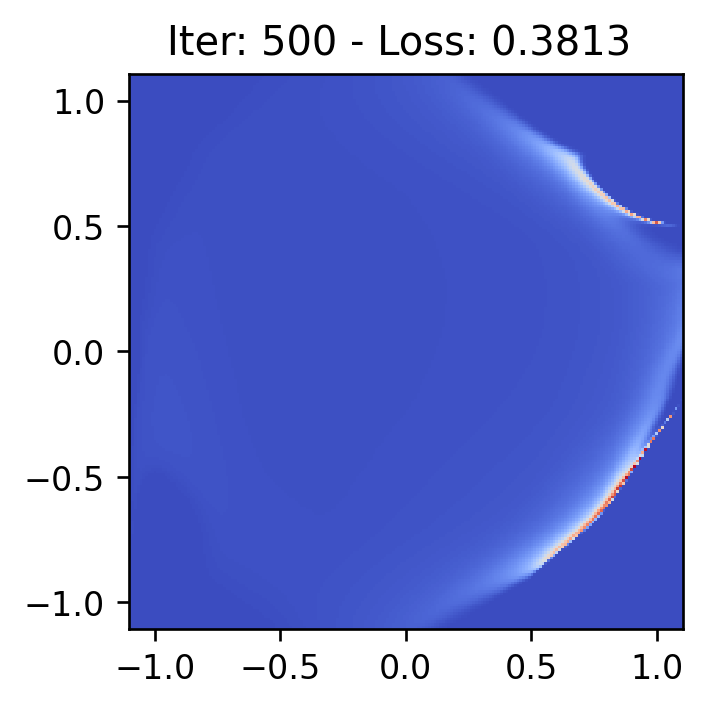

  5%|▍         | 999/20000 [00:18<02:43, 116.39it/s]

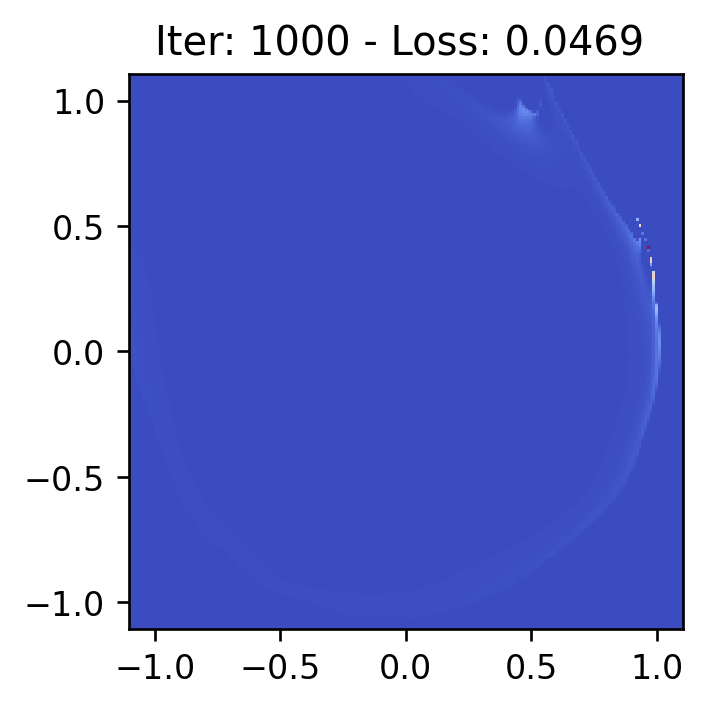

  7%|▋         | 1491/20000 [00:23<02:41, 114.94it/s]

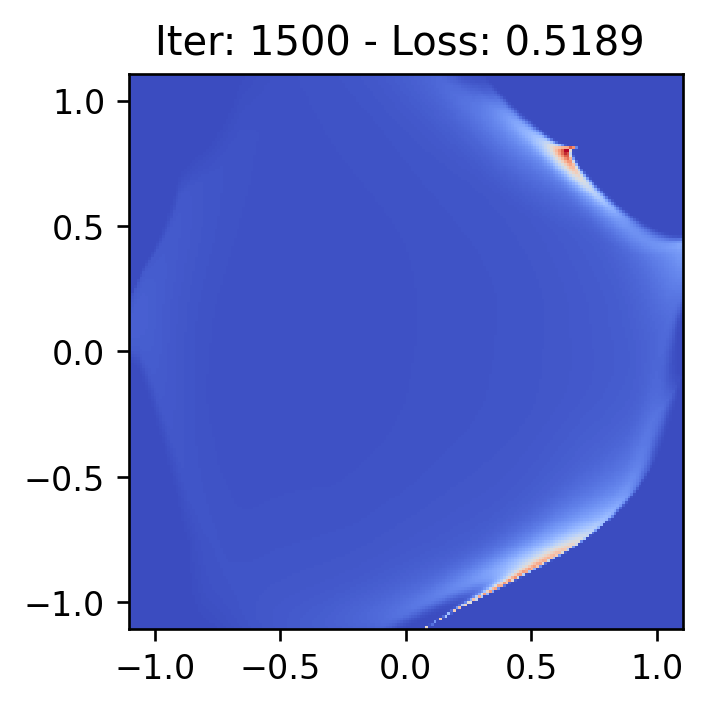

 10%|▉         | 1994/20000 [00:29<02:41, 111.31it/s]

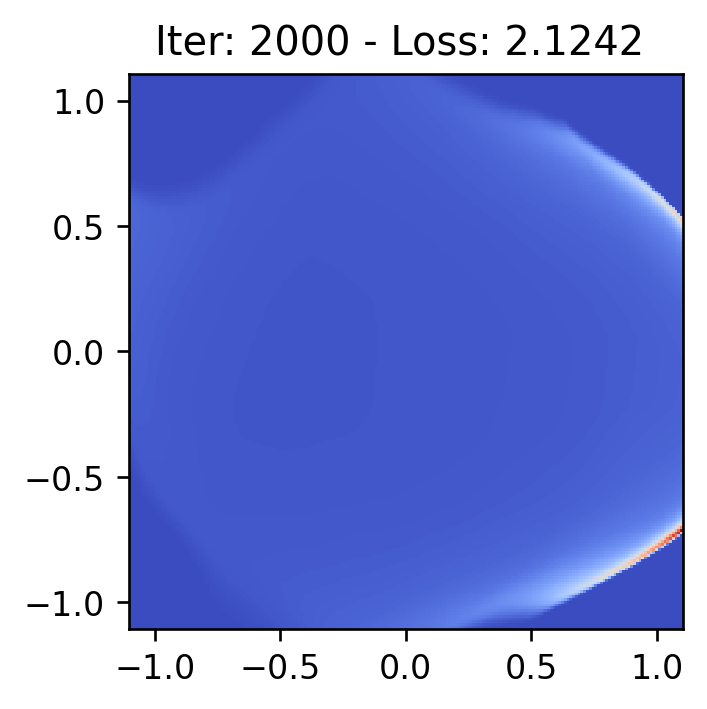

 12%|█▏        | 2493/20000 [00:34<02:46, 104.86it/s]

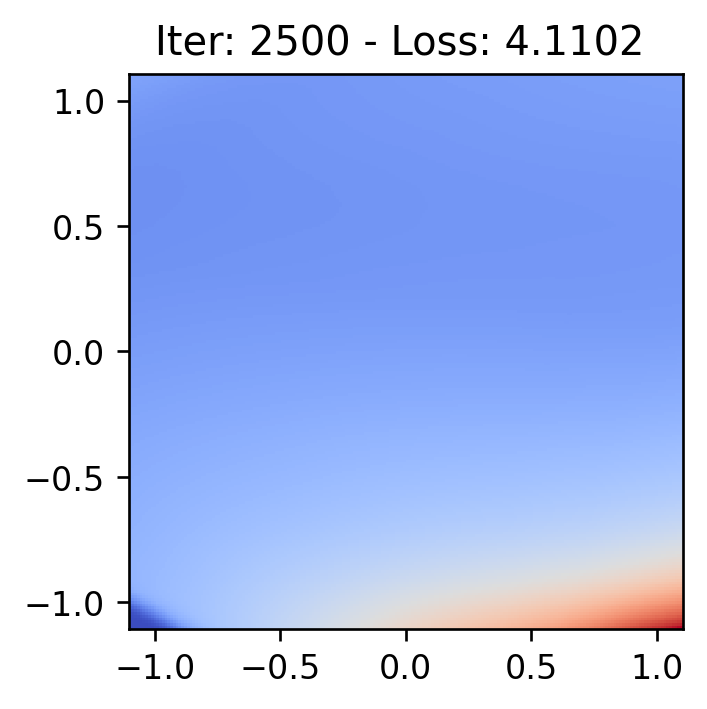

 15%|█▍        | 2991/20000 [00:38<02:35, 109.50it/s]

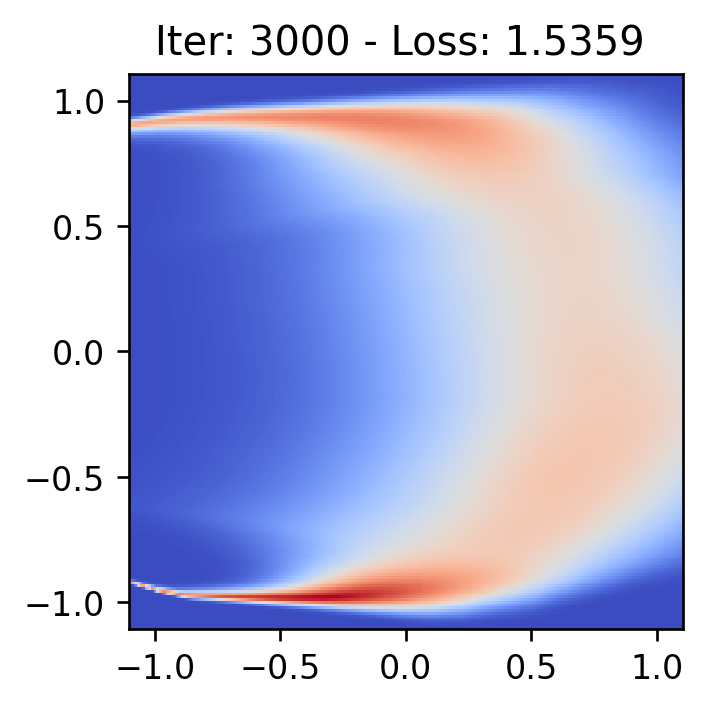

 17%|█▋        | 3497/20000 [00:43<02:29, 110.32it/s]

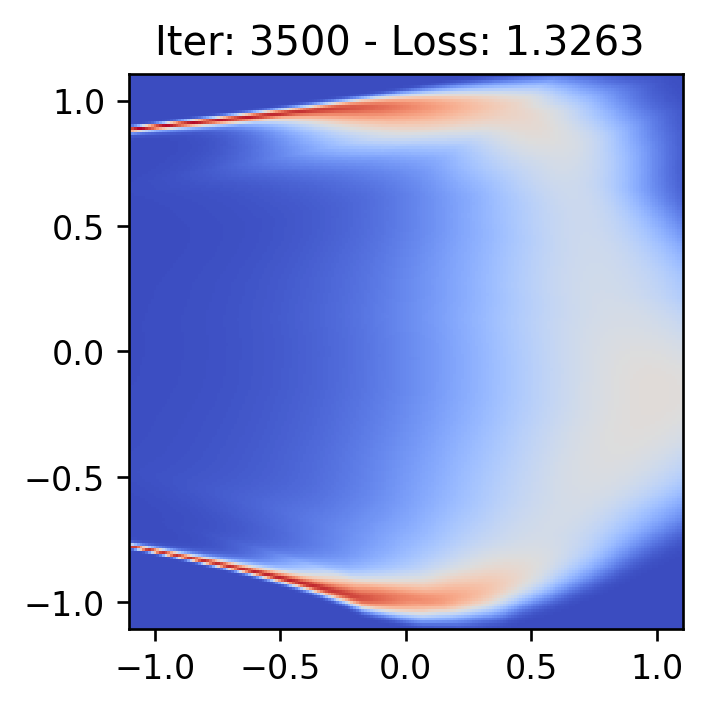

 20%|█▉        | 3994/20000 [00:49<02:26, 108.98it/s]

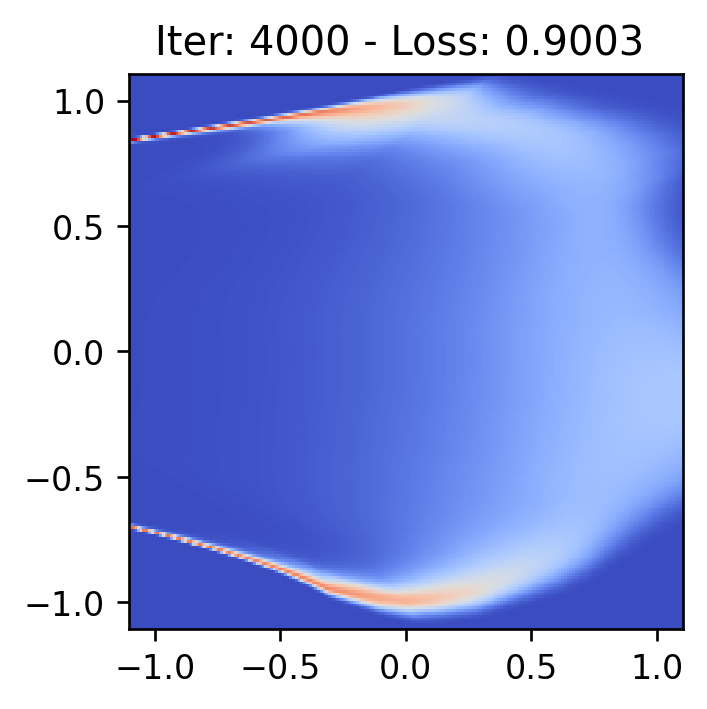

 22%|██▏       | 4497/20000 [00:53<02:19, 110.74it/s]

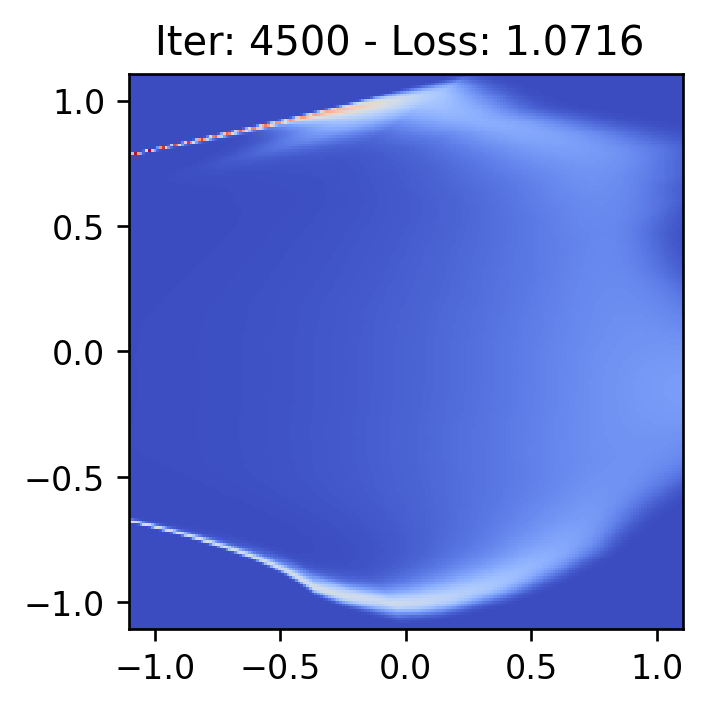

 25%|██▍       | 4996/20000 [00:59<02:25, 103.29it/s]

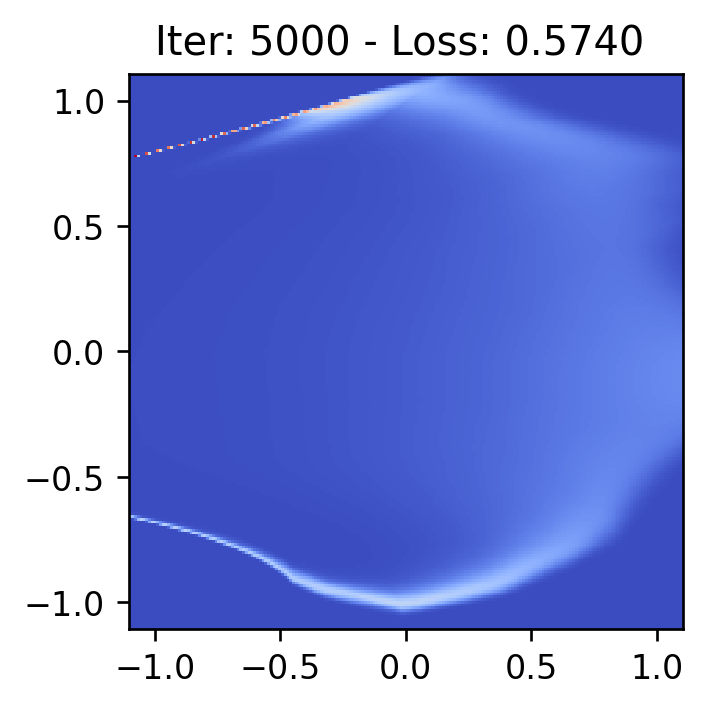

 27%|██▋       | 5490/20000 [01:04<02:08, 112.74it/s]

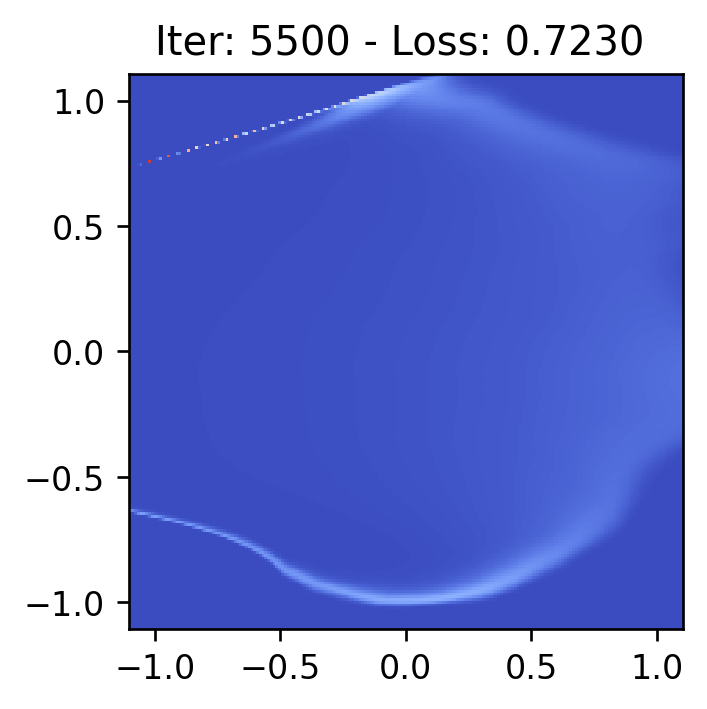

 30%|██▉       | 5991/20000 [01:09<02:58, 78.44it/s]

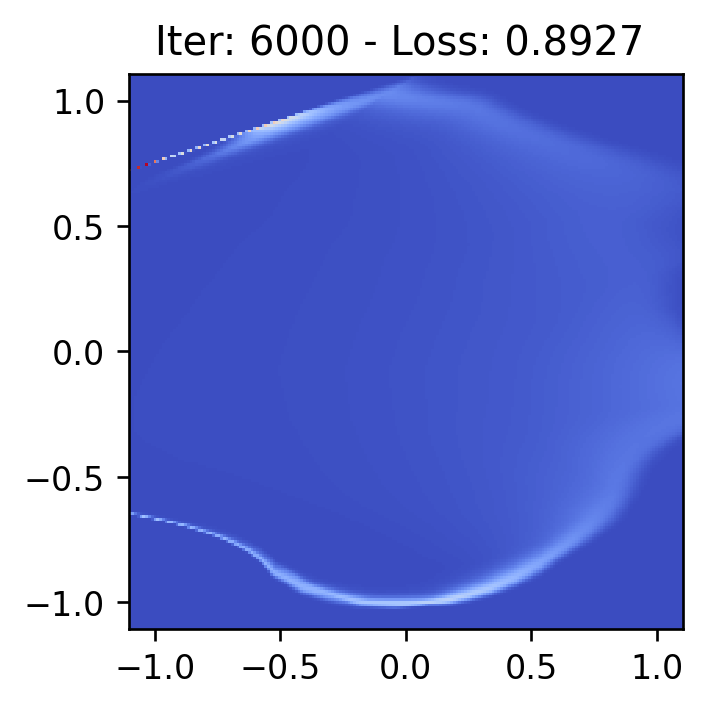

 32%|███▏      | 6493/20000 [01:14<02:02, 109.92it/s]

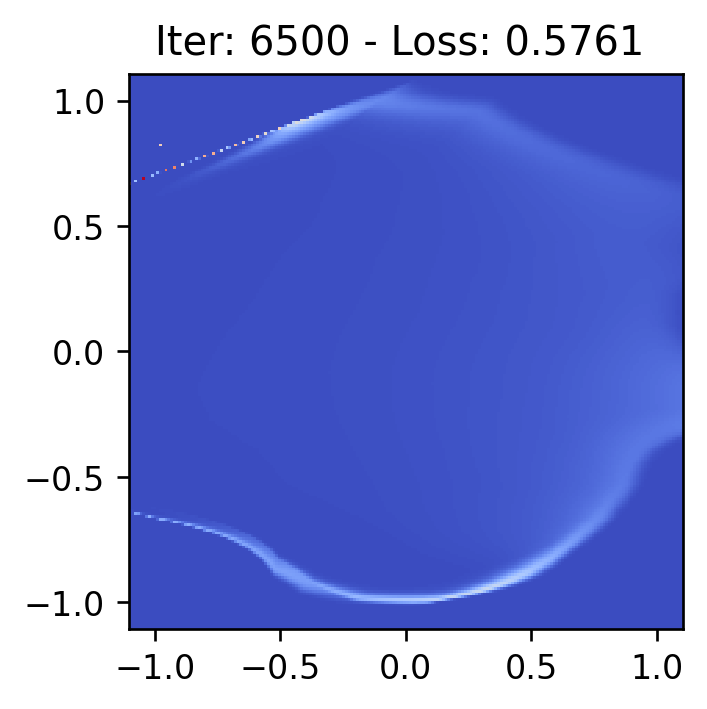

 35%|███▍      | 6995/20000 [01:19<01:56, 111.62it/s]

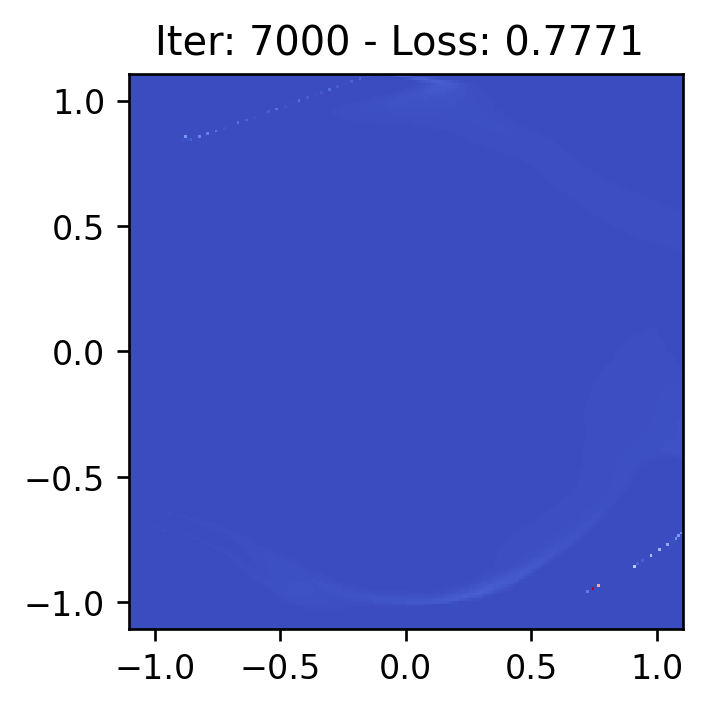

 37%|███▋      | 7488/20000 [01:25<01:56, 107.81it/s]

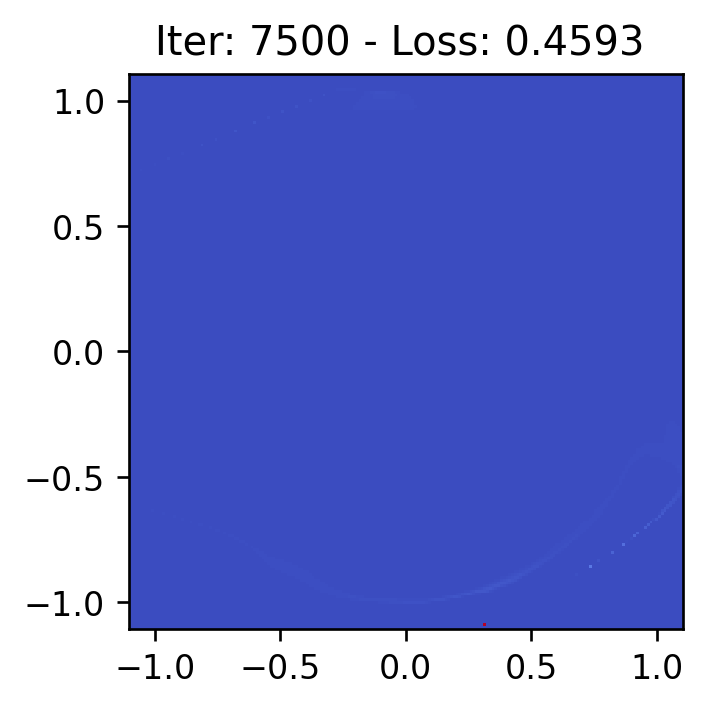

 40%|███▉      | 7989/20000 [01:30<01:55, 103.71it/s]

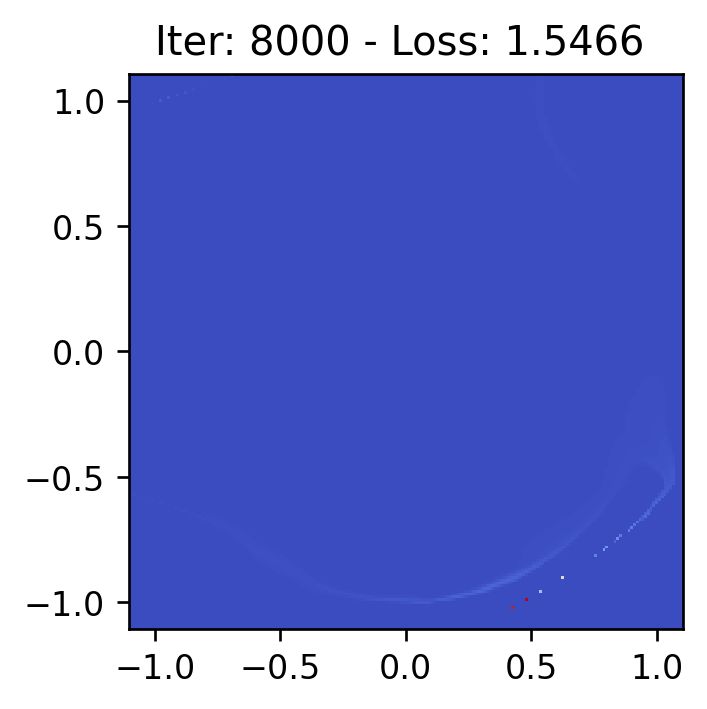

 42%|████▏     | 8496/20000 [01:36<02:13, 86.49it/s]

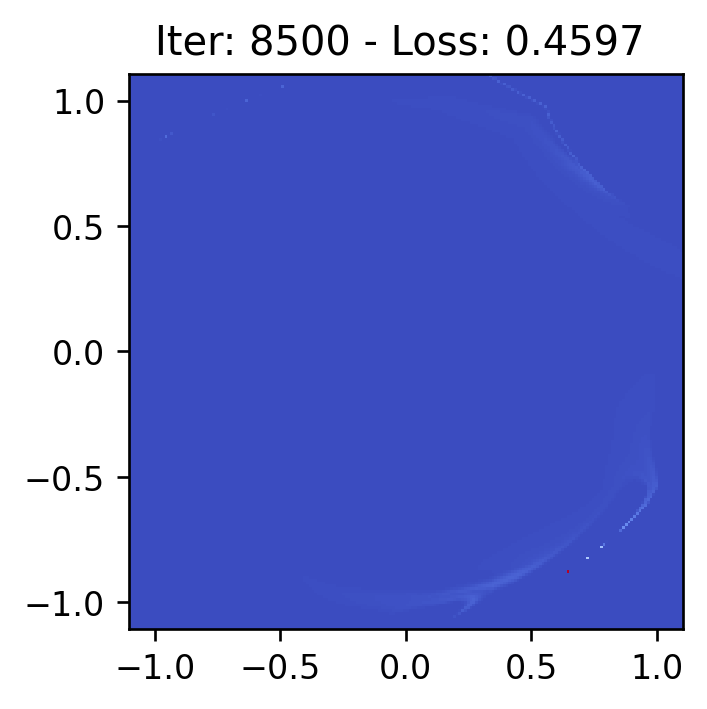

 45%|████▍     | 8995/20000 [01:41<01:40, 109.32it/s]

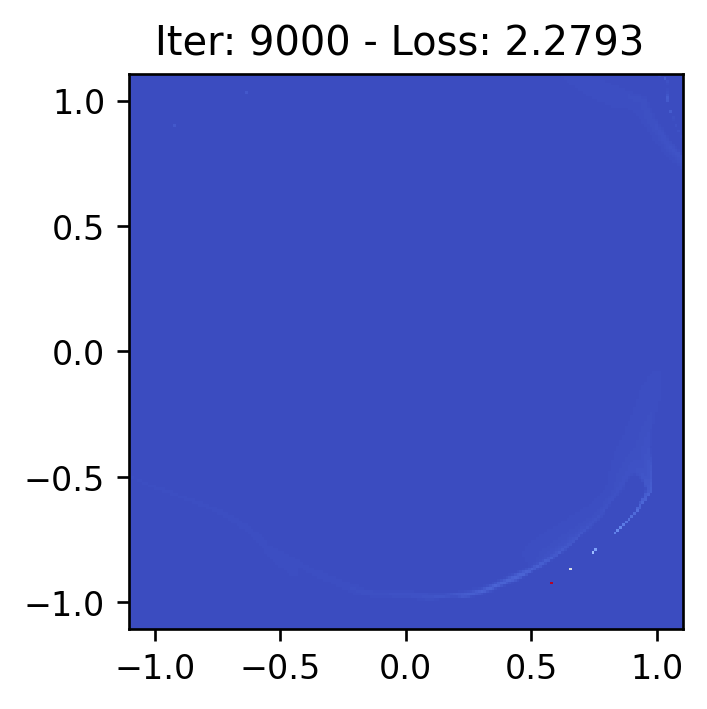

 47%|████▋     | 9495/20000 [01:46<01:33, 111.92it/s]

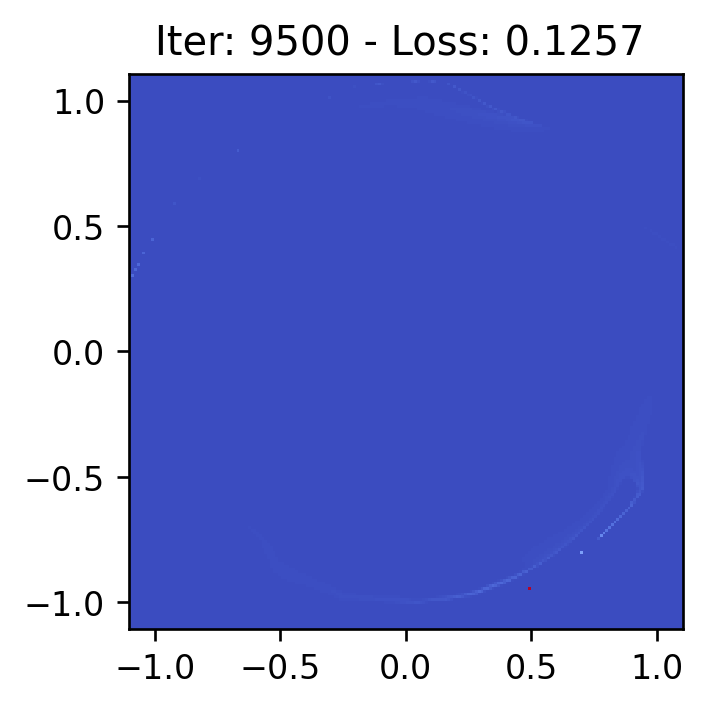

 50%|████▉     | 9997/20000 [01:52<01:30, 110.69it/s]

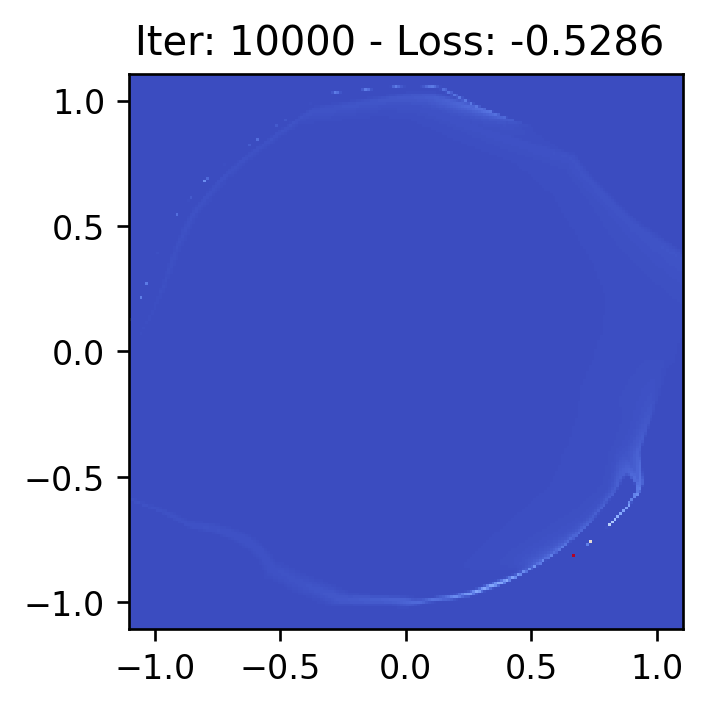

 52%|█████▏    | 10498/20000 [01:57<01:24, 112.38it/s]

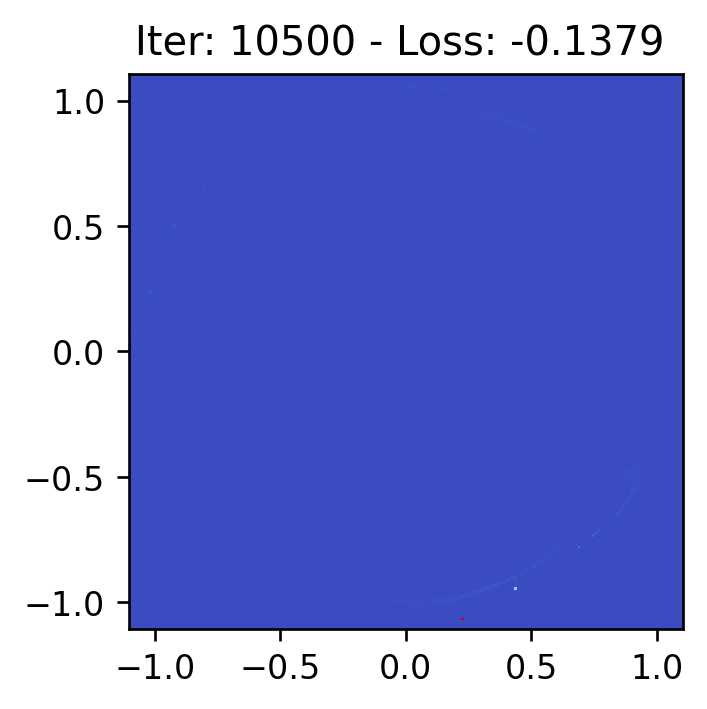

 55%|█████▍    | 10996/20000 [02:02<01:24, 106.40it/s]

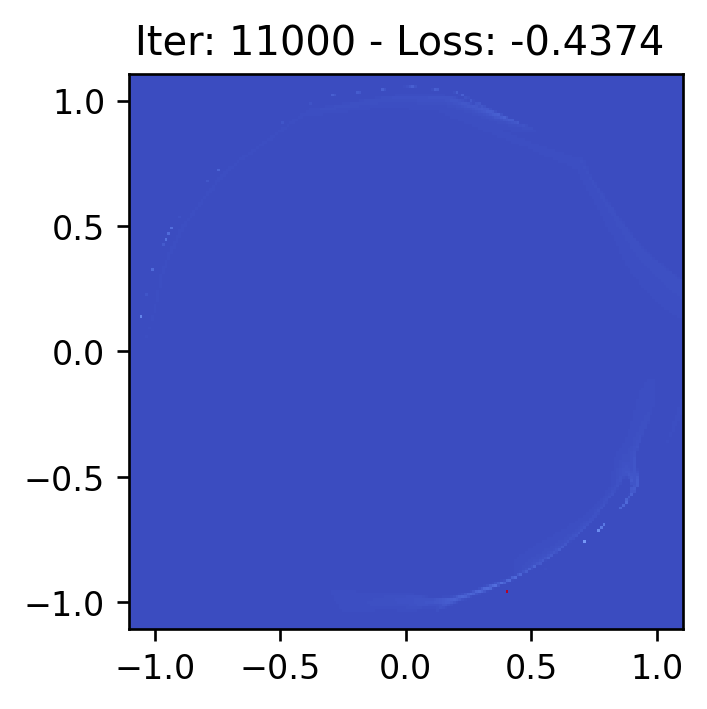

 57%|█████▋    | 11490/20000 [02:07<01:17, 109.86it/s]

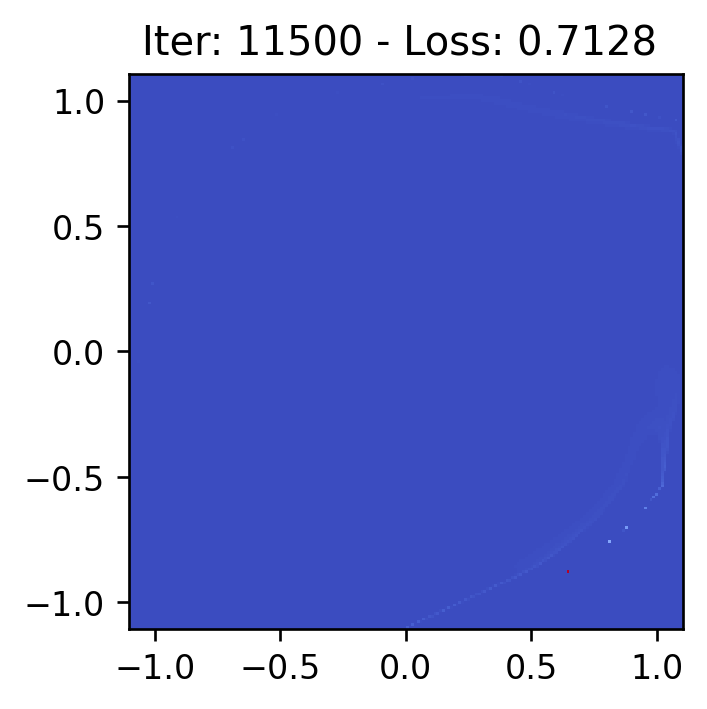

 60%|█████▉    | 11993/20000 [02:12<01:48, 73.46it/s]

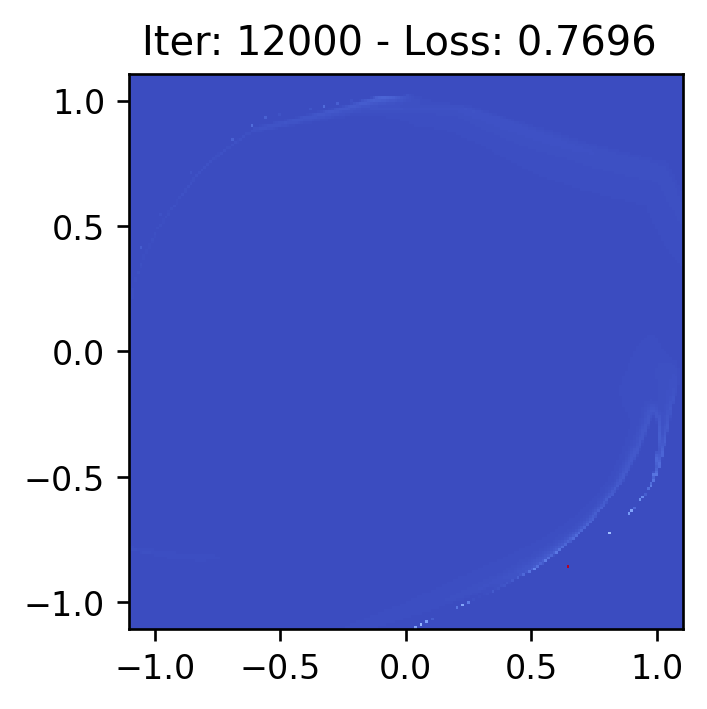

 62%|██████▏   | 12496/20000 [02:18<01:06, 112.12it/s]

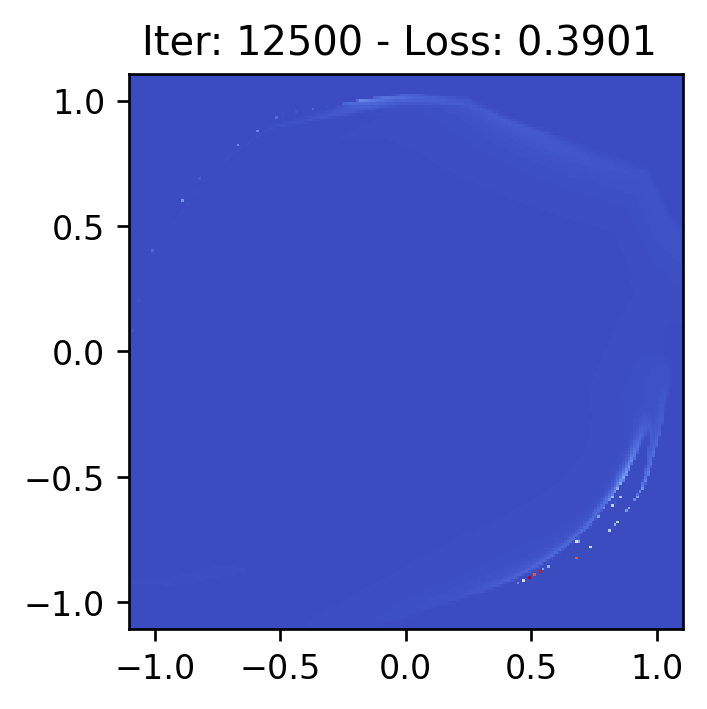

 65%|██████▍   | 12997/20000 [02:22<01:03, 111.06it/s]

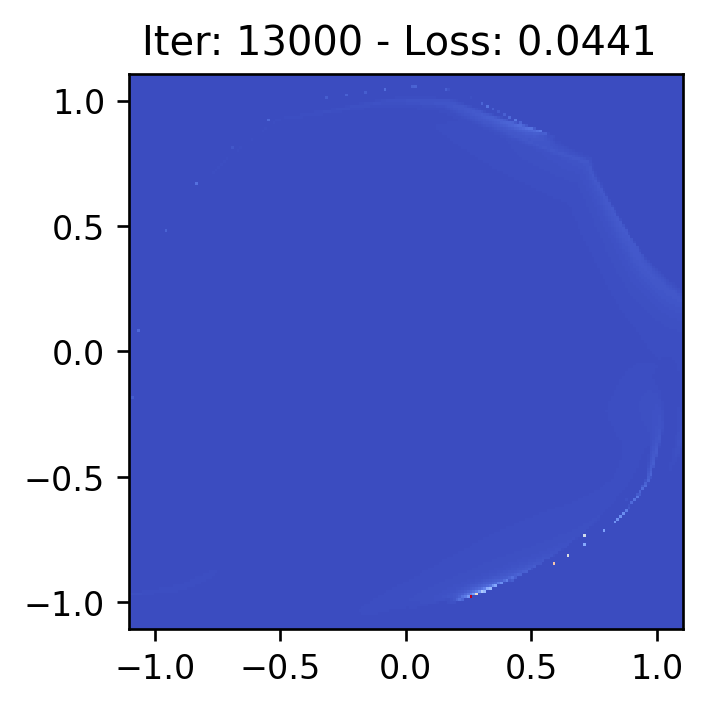

 67%|██████▋   | 13490/20000 [02:28<01:03, 102.36it/s]

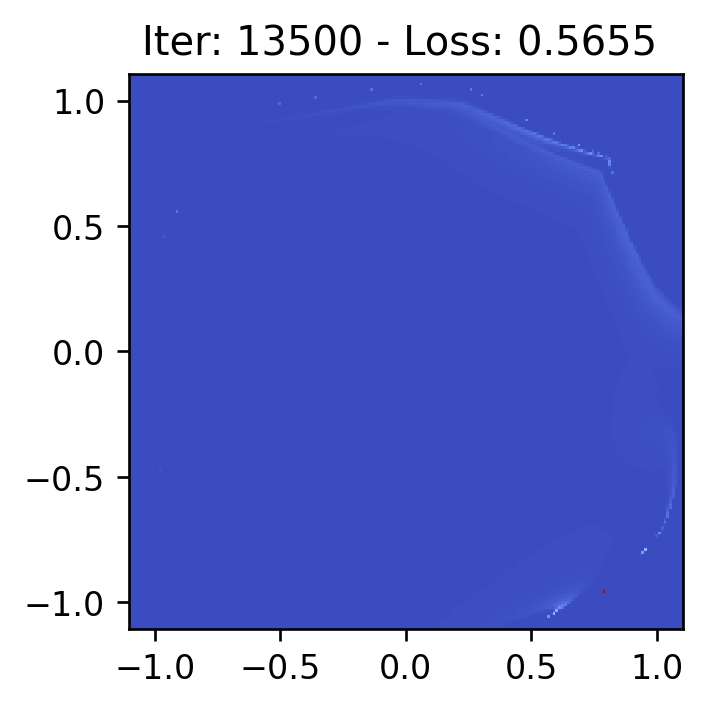

 70%|██████▉   | 13992/20000 [02:33<00:56, 106.93it/s]

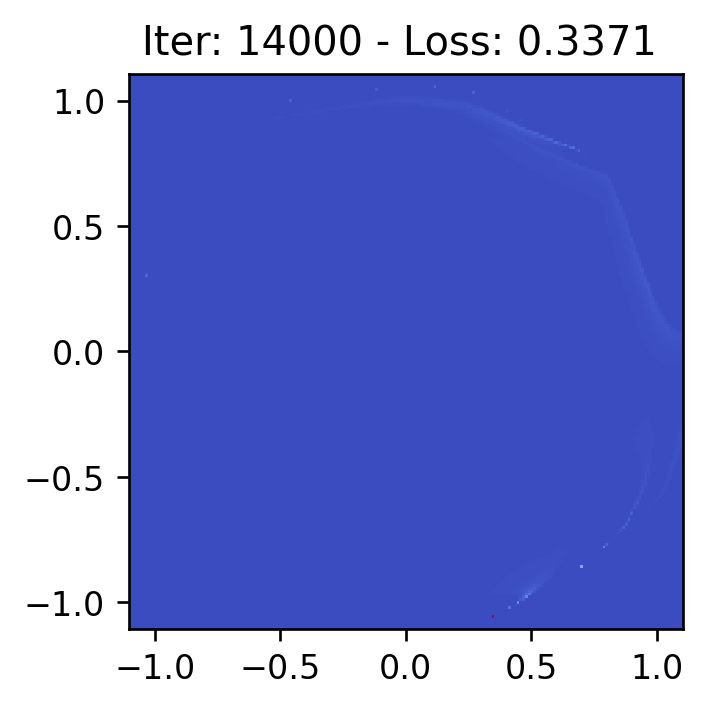

 72%|███████▏  | 14492/20000 [02:38<01:13, 75.37it/s]

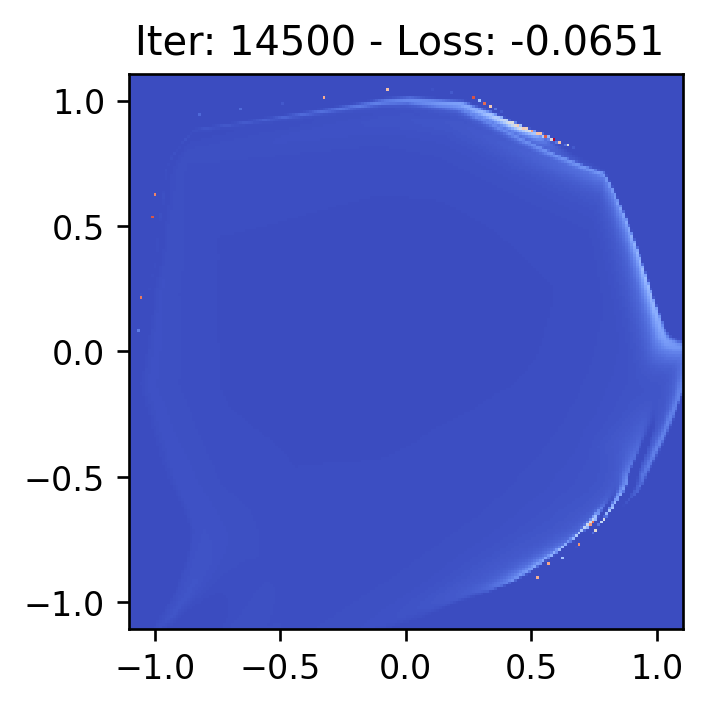

 75%|███████▍  | 14992/20000 [02:43<00:46, 106.84it/s]

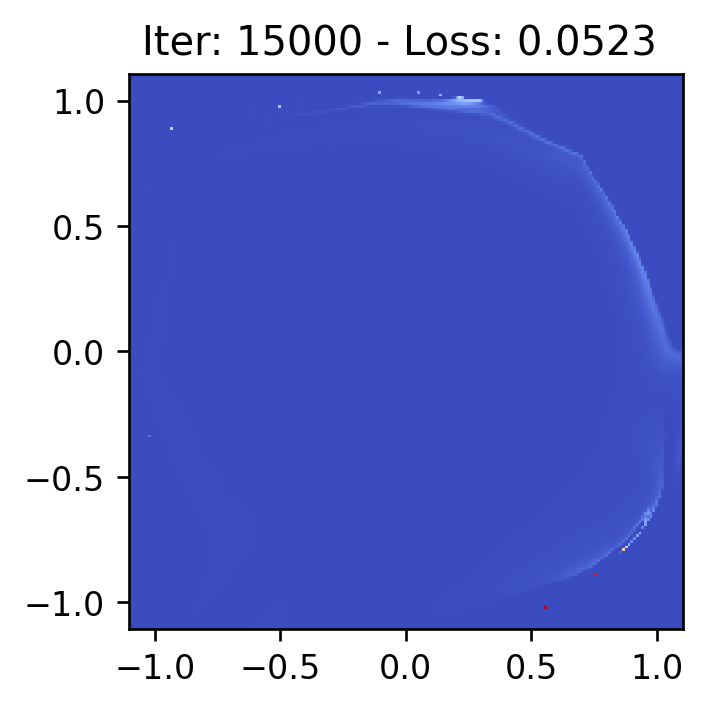

 77%|███████▋  | 15497/20000 [02:49<00:57, 78.55it/s]

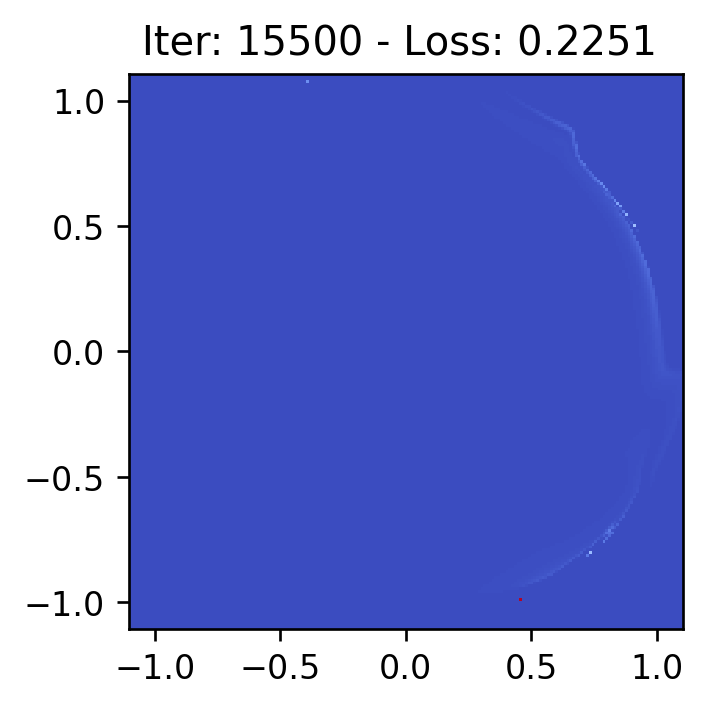

 80%|███████▉  | 15992/20000 [02:55<00:37, 106.48it/s]

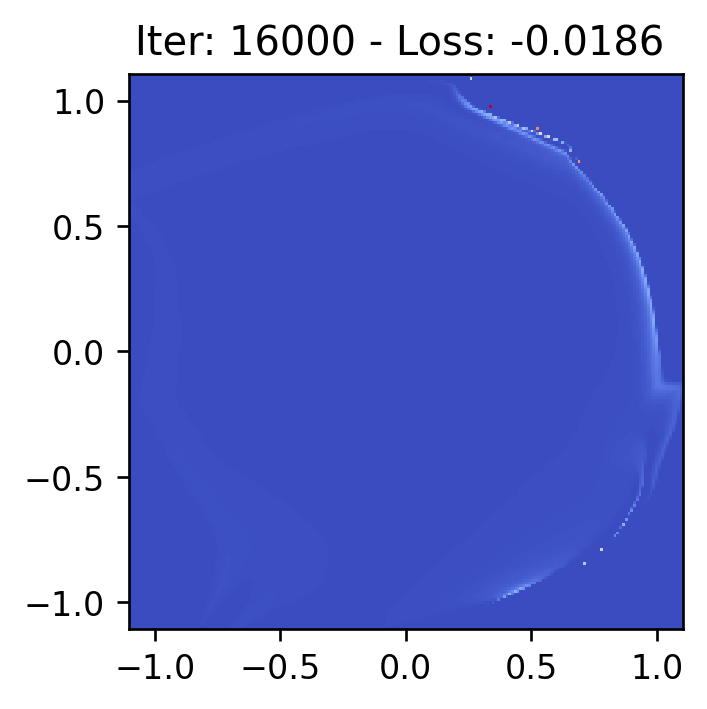

 82%|████████▏ | 16495/20000 [03:00<00:32, 107.27it/s]

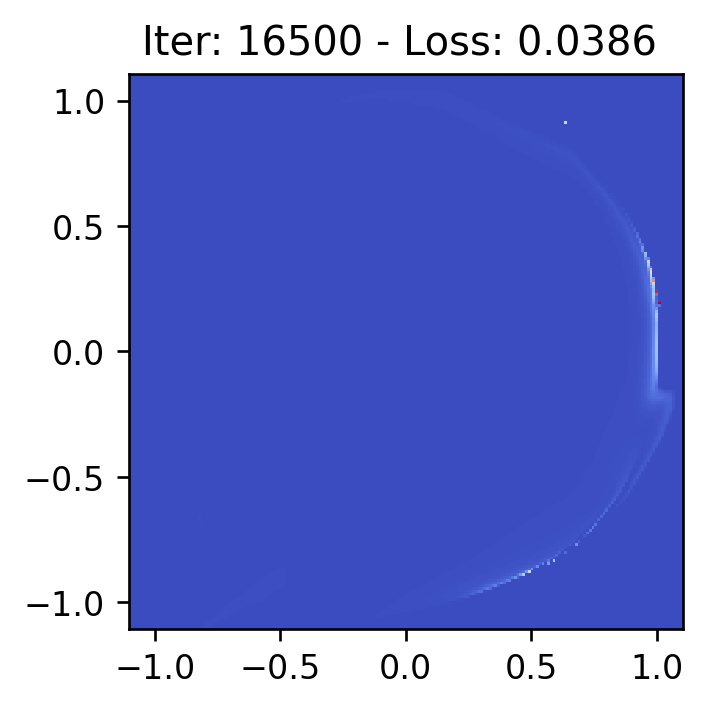

 85%|████████▍ | 16996/20000 [03:05<00:28, 104.02it/s]

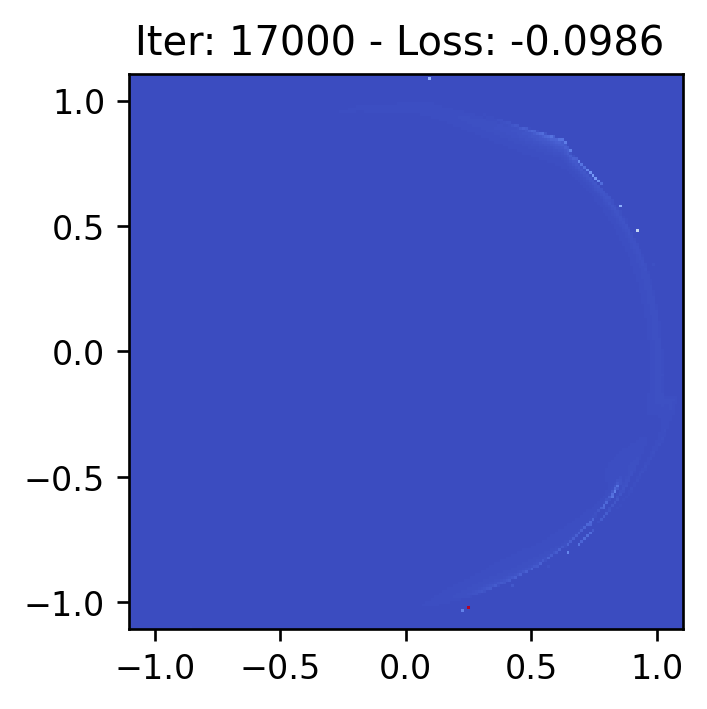

 87%|████████▋ | 17499/20000 [03:10<00:23, 107.52it/s]

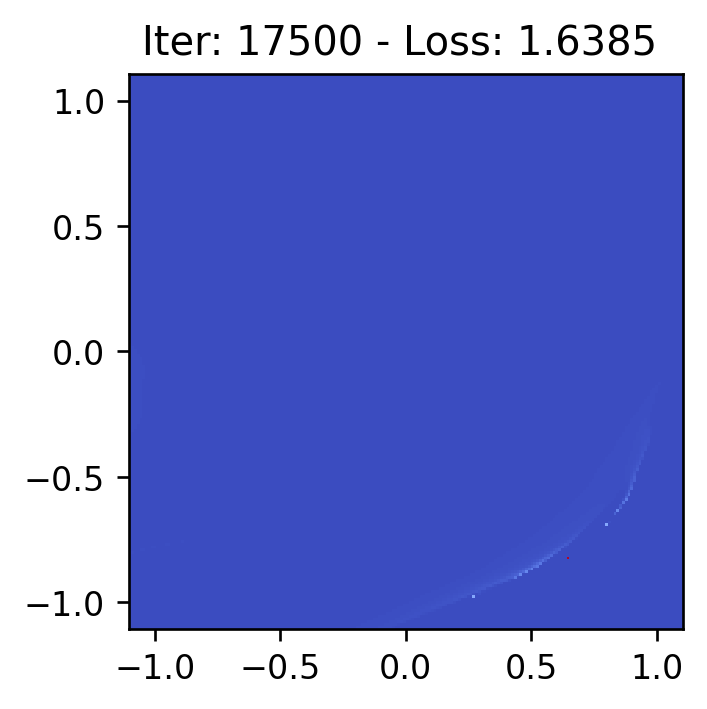

 90%|████████▉ | 17992/20000 [03:16<00:23, 83.73it/s]

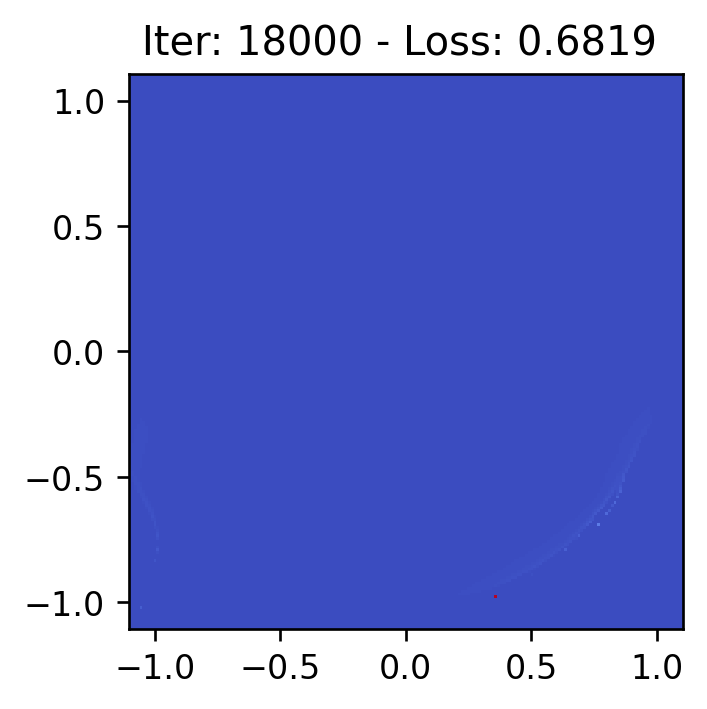

 92%|█████████▏| 18499/20000 [03:21<00:14, 105.92it/s]

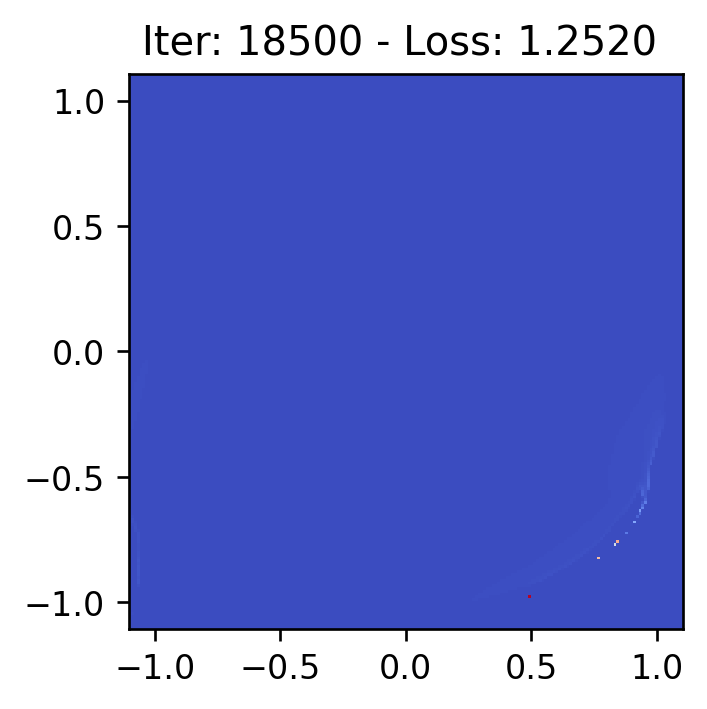

 95%|█████████▍| 18997/20000 [03:26<00:09, 104.87it/s]

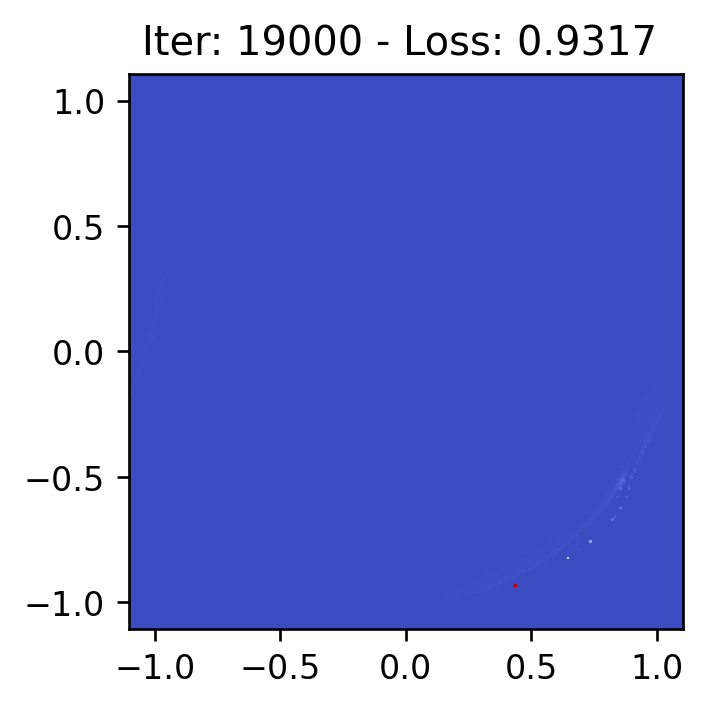

 97%|█████████▋| 19495/20000 [03:32<00:04, 107.30it/s]

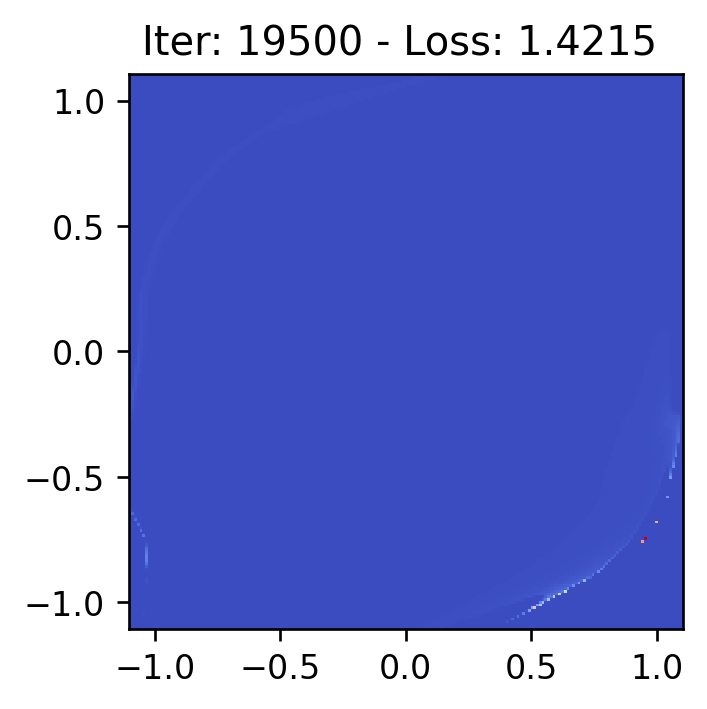

100%|█████████▉| 19993/20000 [03:37<00:00, 95.77it/s]

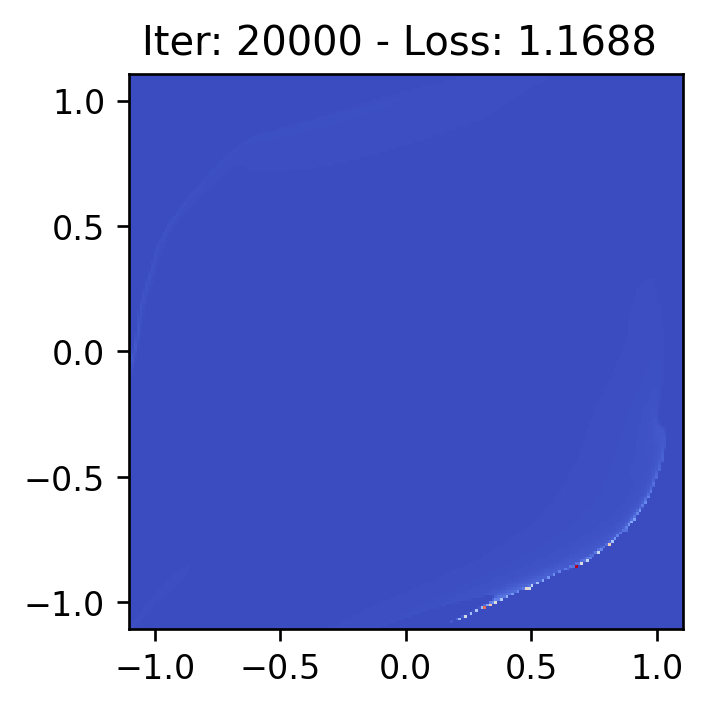

100%|██████████| 20000/20000 [03:37<00:00, 91.95it/s]


In [ ]:
torch.manual_seed(1)

# Train model
max_iter = 20000
show_iter = 500

loss_hist = np.array([])

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)

for it in tqdm(range(max_iter)):
    optimizer.zero_grad()

    try:
        x = next(train_iterator)[0]
    except StopIteration:
        train_iterator = iter(train_loader)
        x = next(train_iterator)[0]


    # Compute loss
    loss = model.forward_kld(x)

    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer.step()

    # Log loss
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())

    # Plot learned distribution
    if (it + 1) % show_iter == 0:
        model.eval()
        log_prob = model.log_prob(zz)
        model.train()
        prob = torch.exp(log_prob.to('cpu').view(*xx.shape))
        prob[torch.isnan(prob)] = 0

        plt.figure(figsize=(3, 3), dpi=240)
        plt.pcolormesh(xx, yy, prob.data.numpy(), cmap='coolwarm')
        plt.gca().set_aspect('equal', 'box')
        plt.title("Iter: {} - Loss: {:.4f} ".format(it+1, loss))
        plt.show()

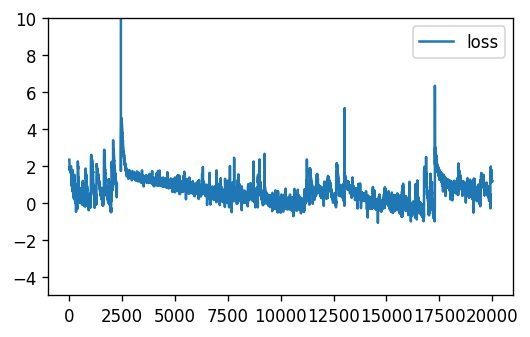

In [ ]:
plt.figure(figsize=(5, 3), dpi=120)
plt.plot(loss_hist, label='loss')
plt.ylim([-5, 10])
plt.legend()
plt.show()

## Mollification

### Noise schedule

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_schedule(t, start=-3, end=3, tau=1.0, clip_min=1e-9, N_max=1):
    t = t / N_max
    v_start = sigmoid(start / tau)
    v_end = sigmoid(end / tau)
    output = sigmoid((t * (end - start) + start) / tau)
    output = (v_end - output) / (v_end - v_start)
    return np.clip(output, clip_min, 1.)

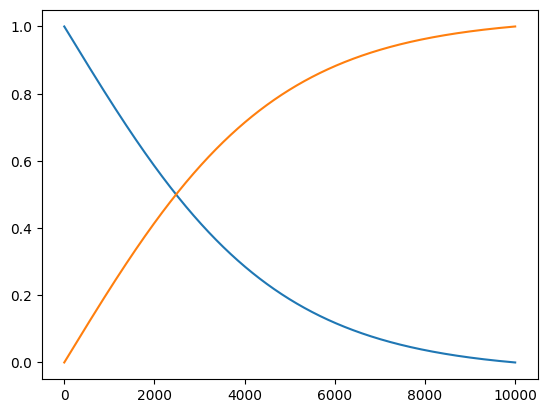

In [ ]:
max_iter = 10000
iters = np.arange(max_iter)
noises = sigmoid_schedule(iters, start=0, end=3, tau=0.7, N_max=max_iter)

plt.plot(iters, noises)
plt.plot(iters, 1-noises)
plt.show()

In [ ]:
model = get_model()

  2%|▏         | 498/20000 [00:05<03:00, 107.98it/s]

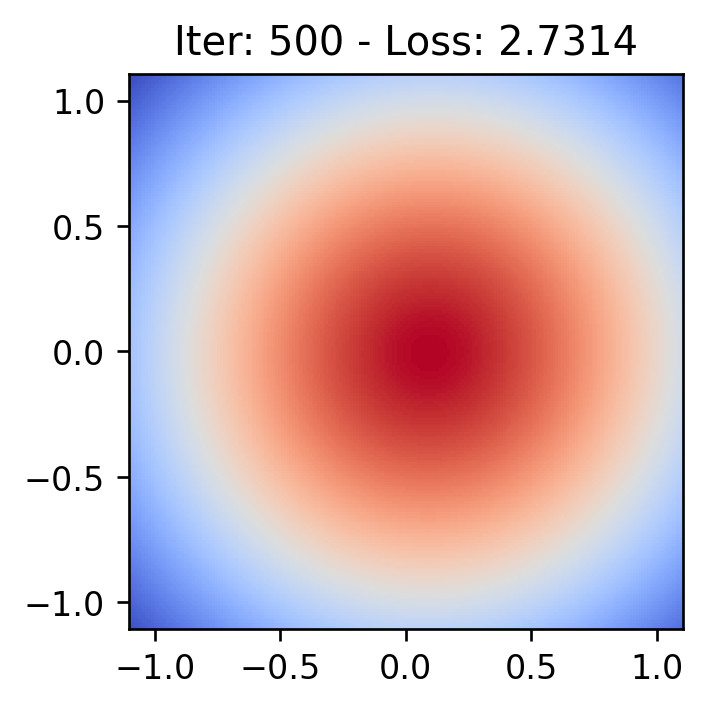

  5%|▍         | 990/20000 [00:09<02:50, 111.67it/s]

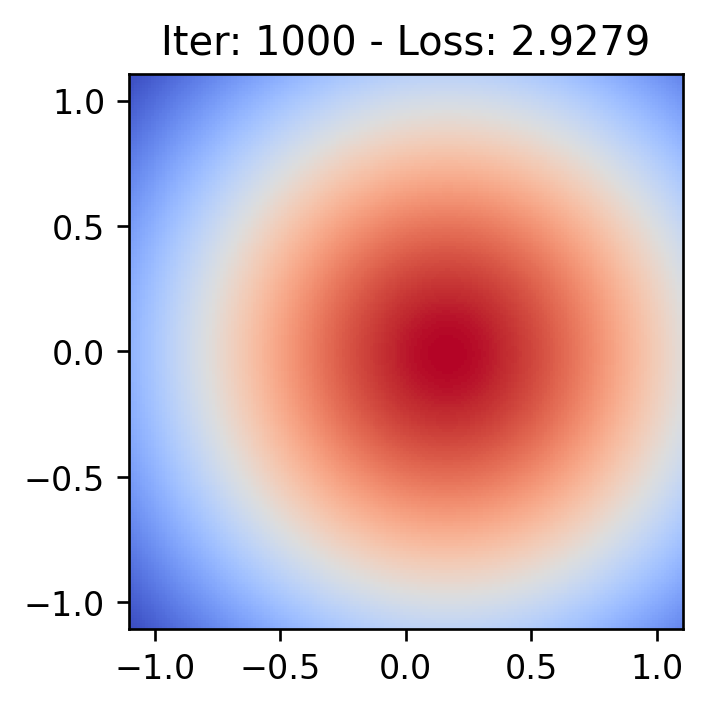

  7%|▋         | 1494/20000 [00:14<03:24, 90.44it/s]

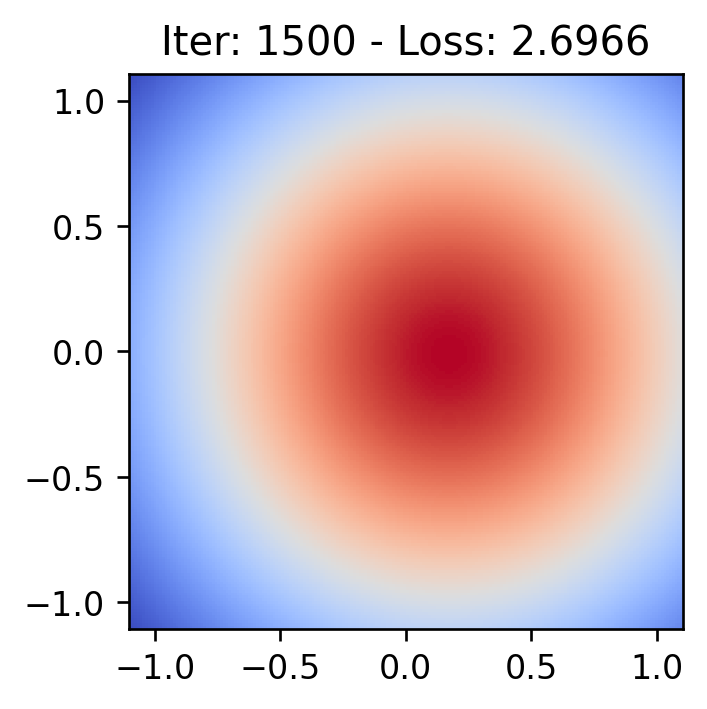

 10%|▉         | 1991/20000 [00:20<02:45, 108.66it/s]

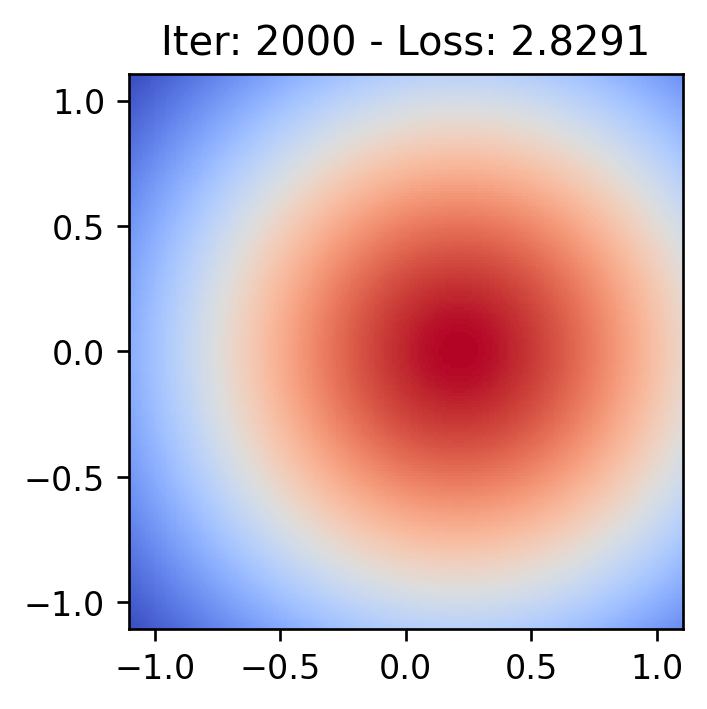

 12%|█▏        | 2490/20000 [00:25<02:35, 112.77it/s]

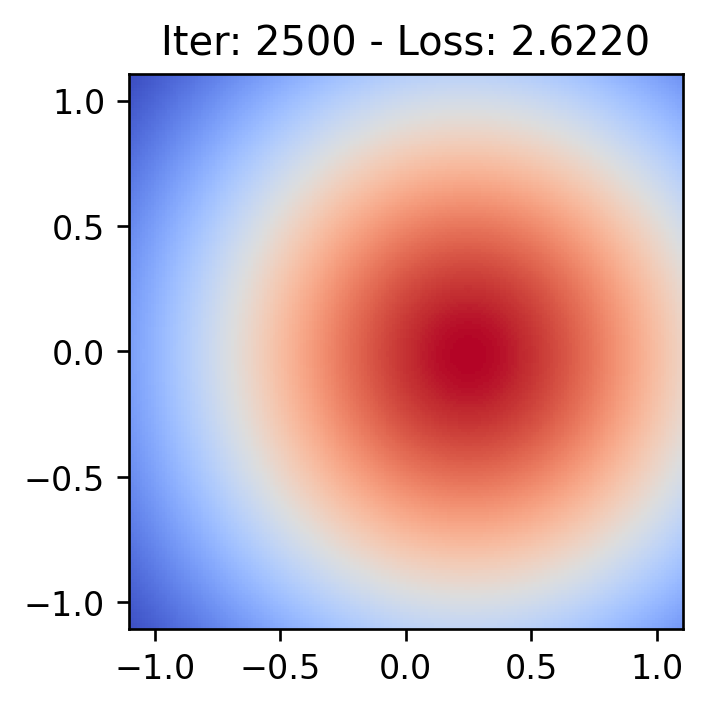

 15%|█▍        | 2997/20000 [00:30<02:42, 104.32it/s]

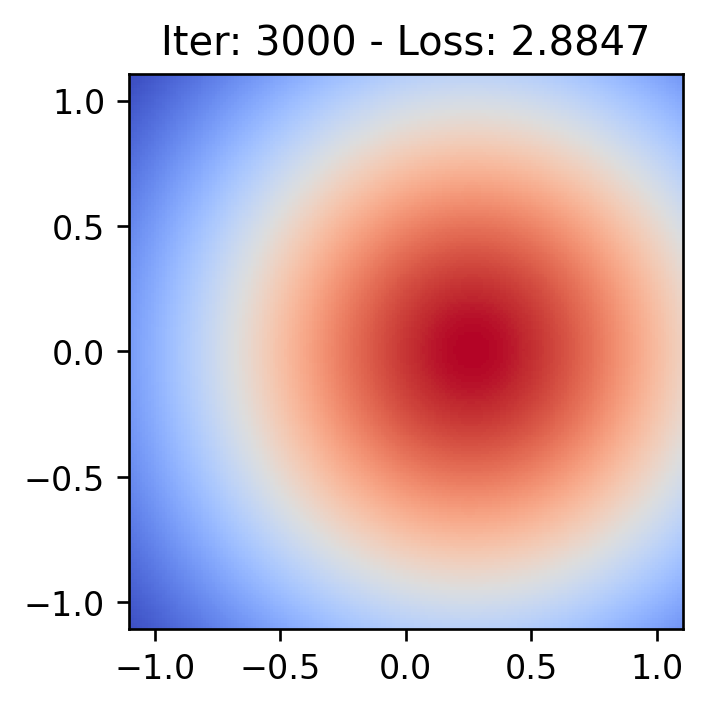

 17%|█▋        | 3492/20000 [00:35<02:28, 111.39it/s]

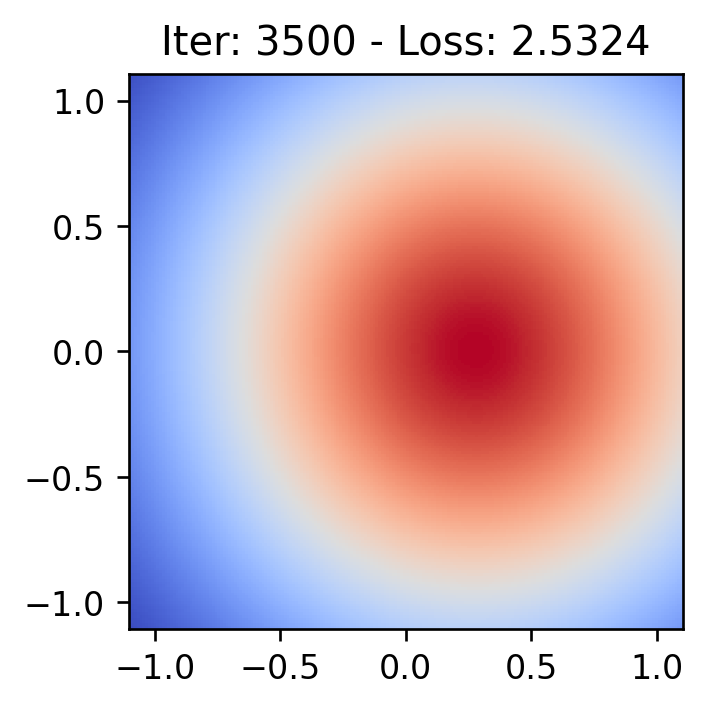

 20%|█▉        | 3999/20000 [00:40<03:36, 73.91it/s]

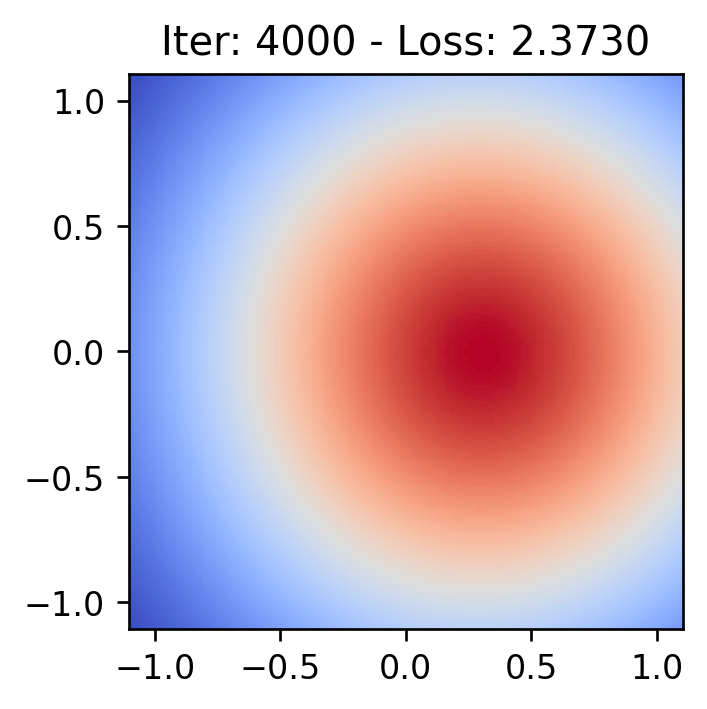

 22%|██▏       | 4497/20000 [00:45<02:23, 108.26it/s]

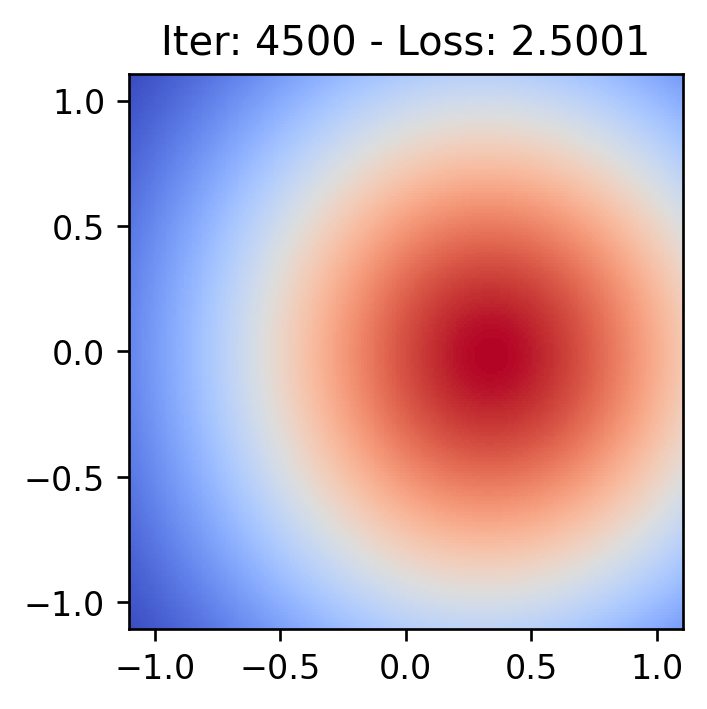

 25%|██▍       | 4998/20000 [00:50<02:15, 111.08it/s]

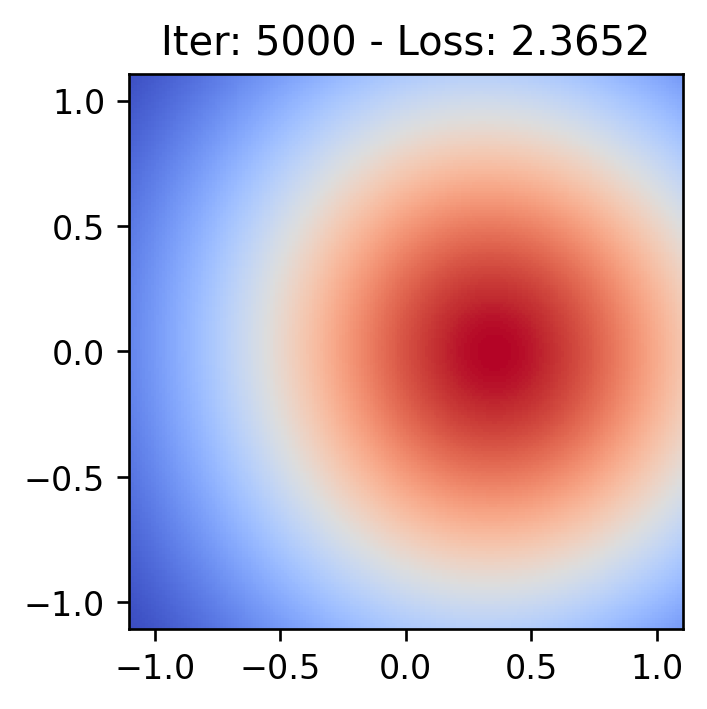

 27%|██▋       | 5499/20000 [00:56<02:15, 107.23it/s]

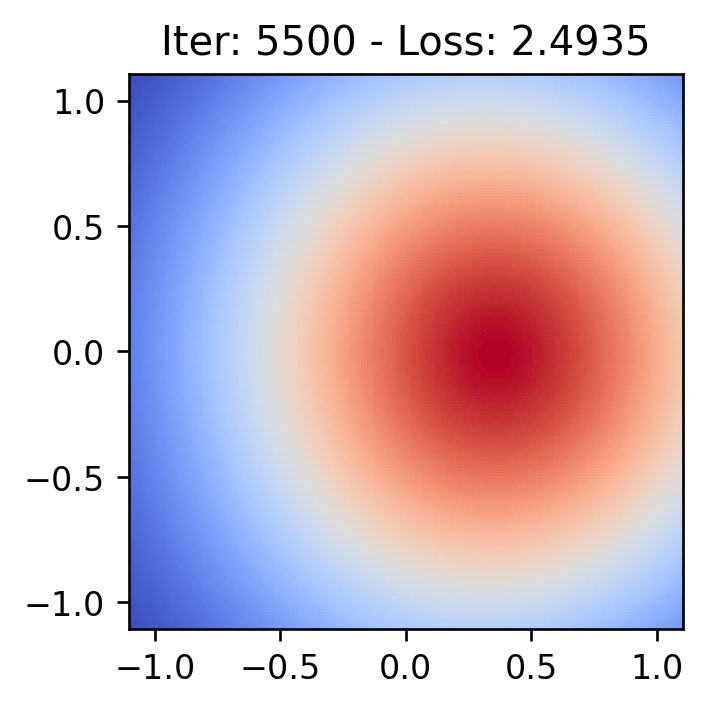

 30%|██▉       | 5993/20000 [01:01<02:16, 102.61it/s]

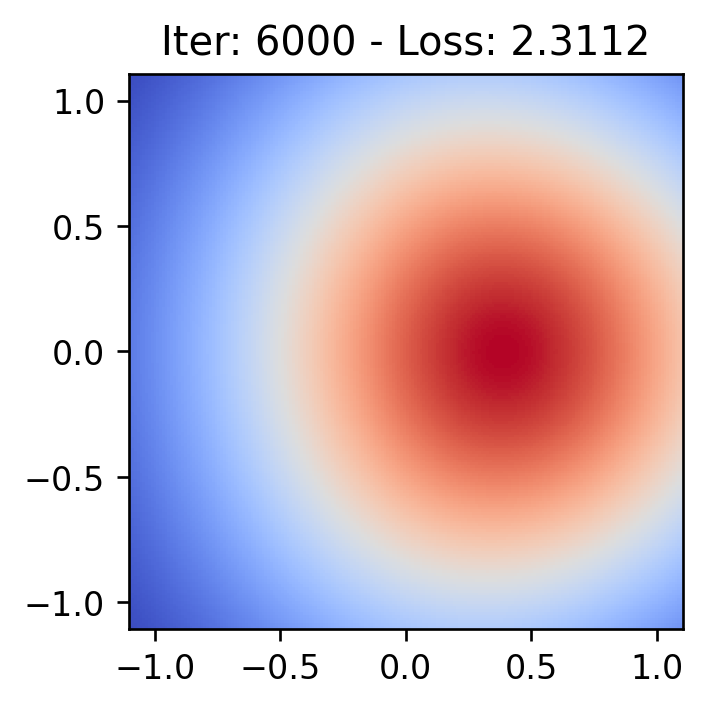

 32%|███▏      | 6490/20000 [01:07<02:13, 101.47it/s]

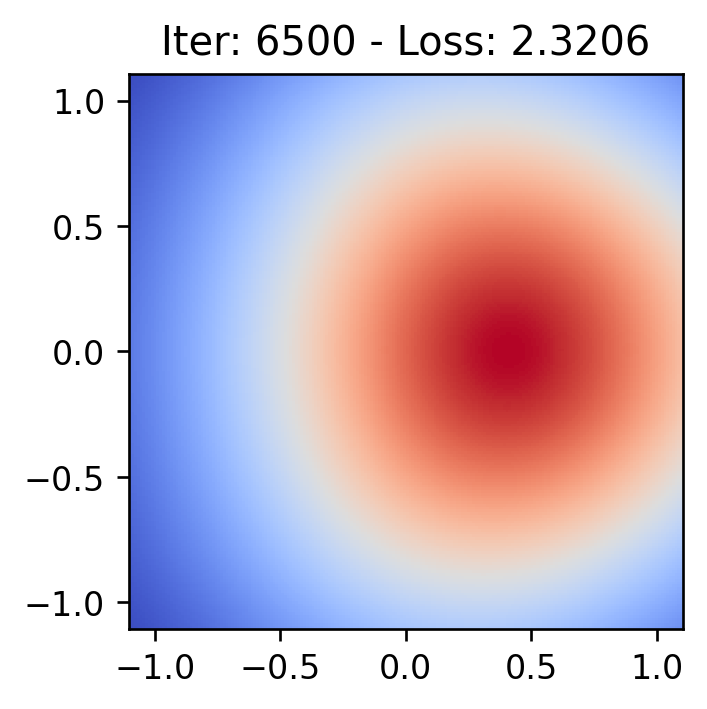

 35%|███▍      | 6990/20000 [01:12<02:02, 106.25it/s]

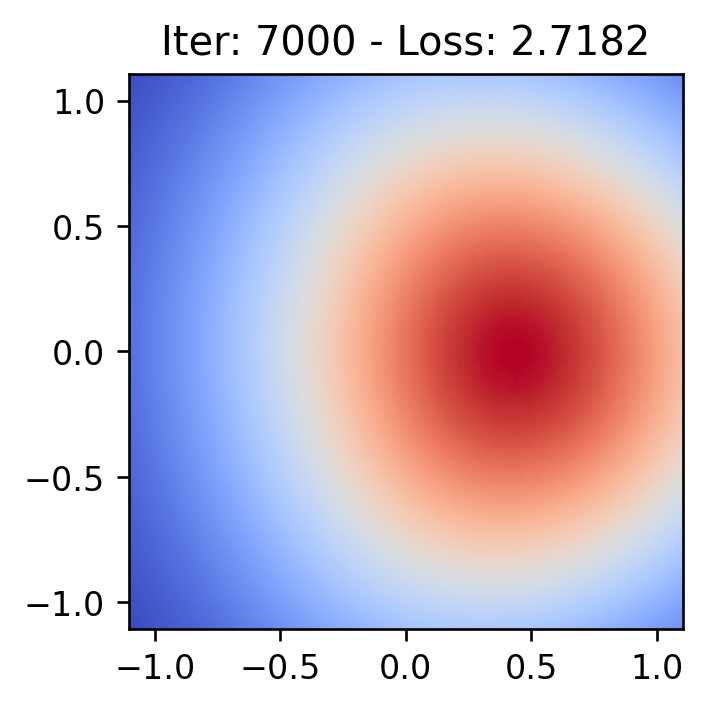

 37%|███▋      | 7493/20000 [01:17<02:28, 84.03it/s]

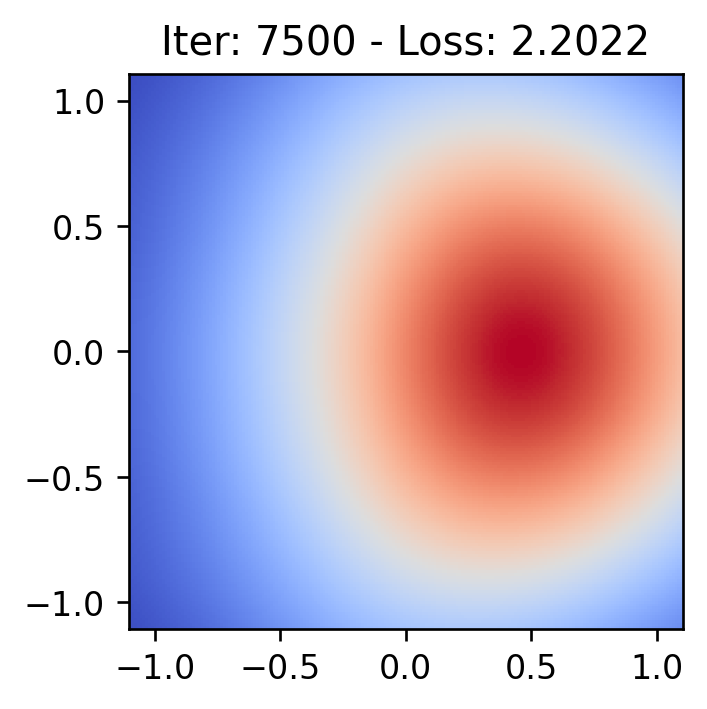

 40%|███▉      | 7999/20000 [01:23<01:52, 106.97it/s]

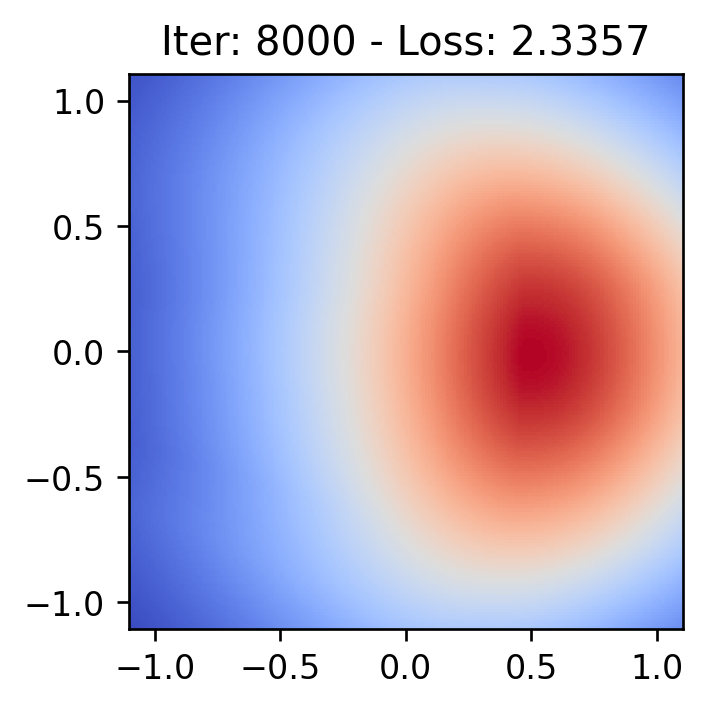

 42%|████▏     | 8489/20000 [01:28<01:47, 107.54it/s]

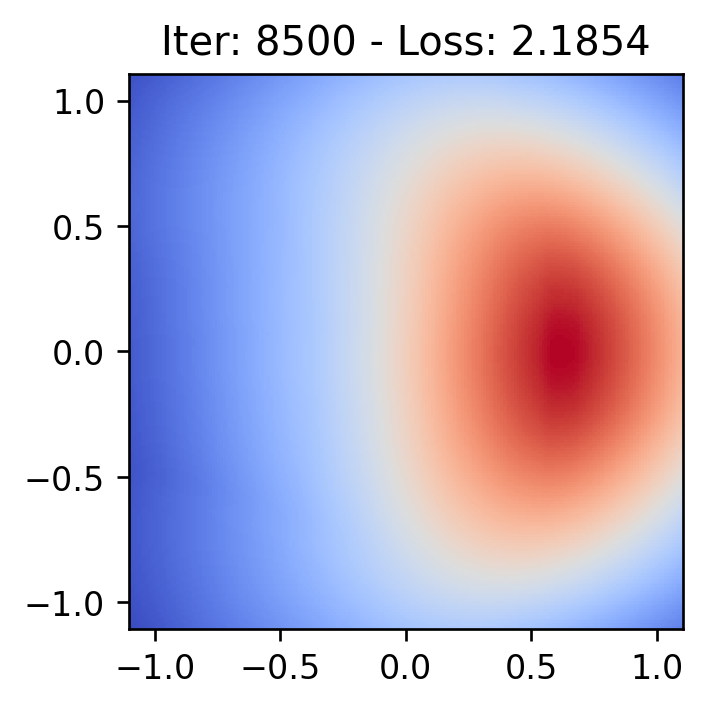

 45%|████▍     | 8997/20000 [01:36<03:29, 52.41it/s]

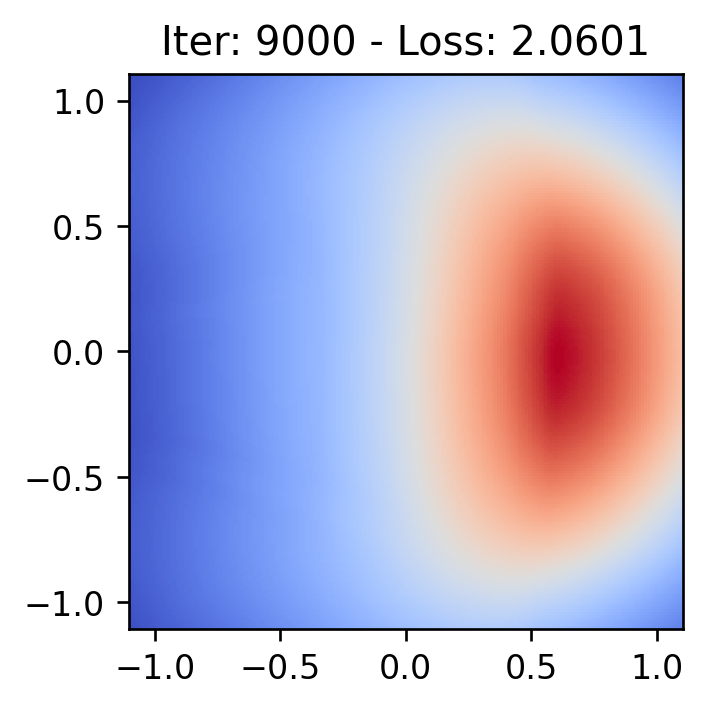

 47%|████▋     | 9493/20000 [01:45<02:11, 80.17it/s]

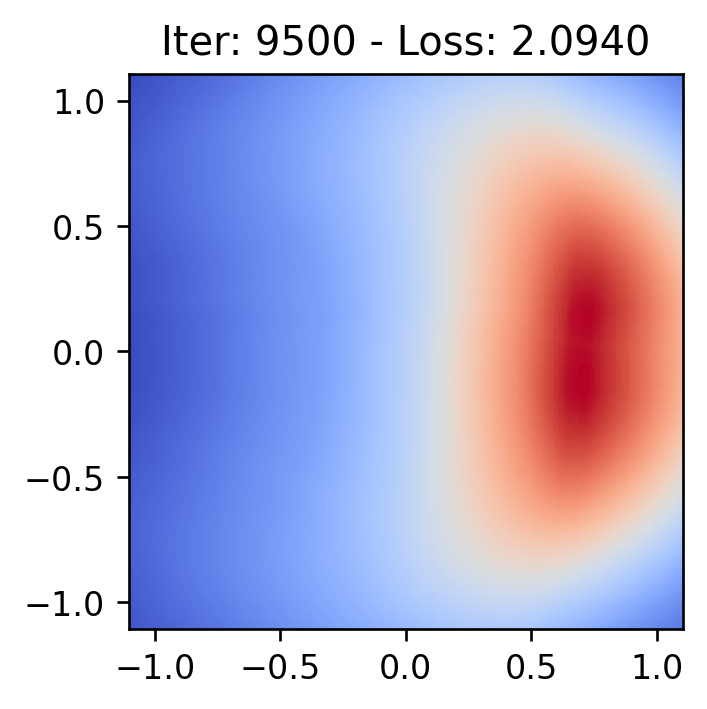

 50%|████▉     | 9992/20000 [01:51<02:07, 78.57it/s]

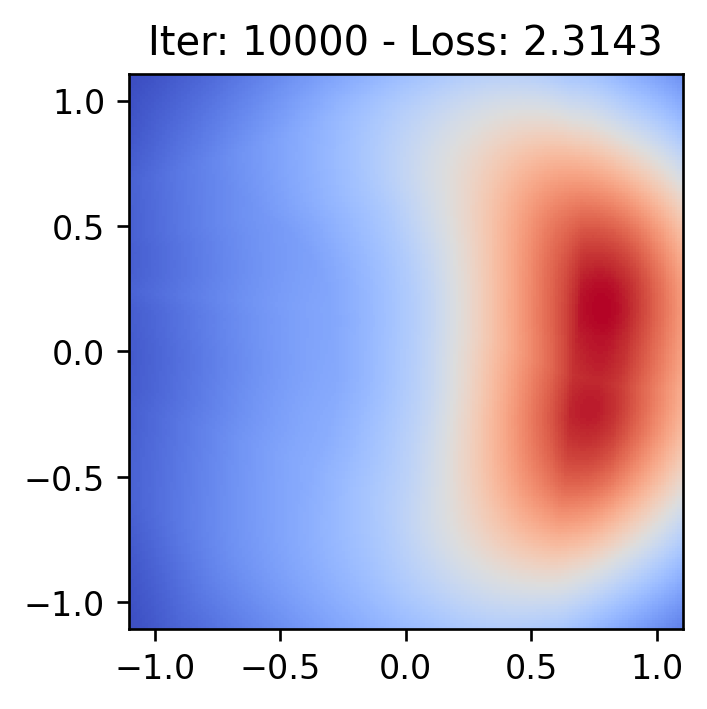

 52%|█████▏    | 10495/20000 [01:59<02:24, 65.68it/s]

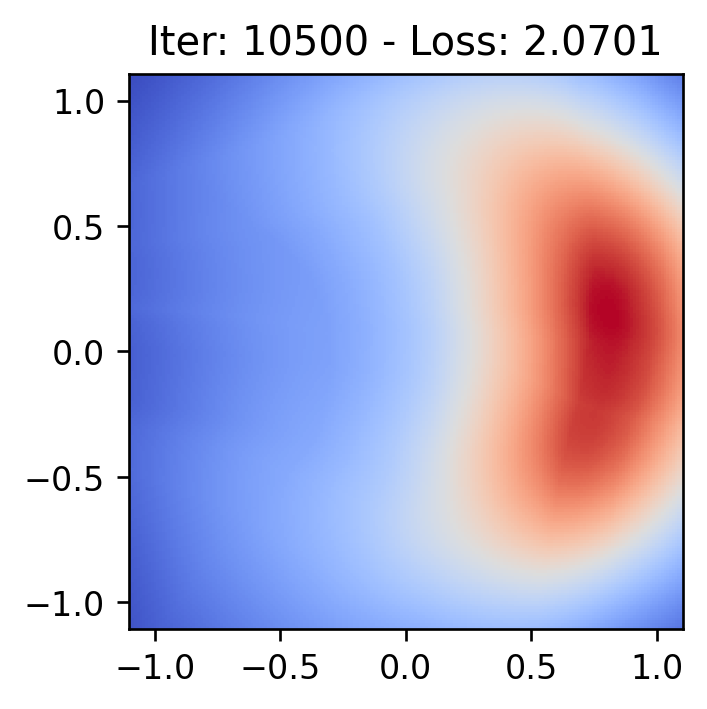

 55%|█████▍    | 10993/20000 [02:04<01:27, 102.79it/s]

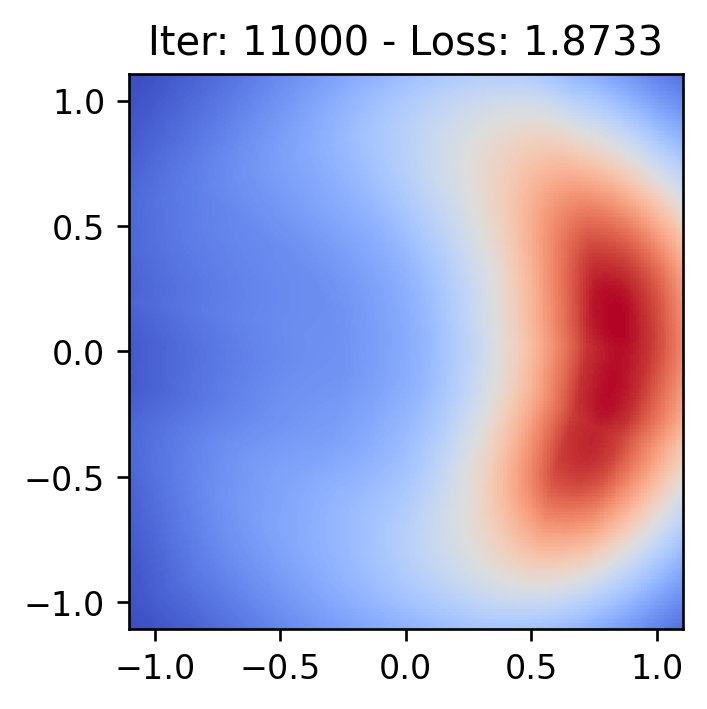

 57%|█████▋    | 11498/20000 [02:10<02:07, 66.89it/s]

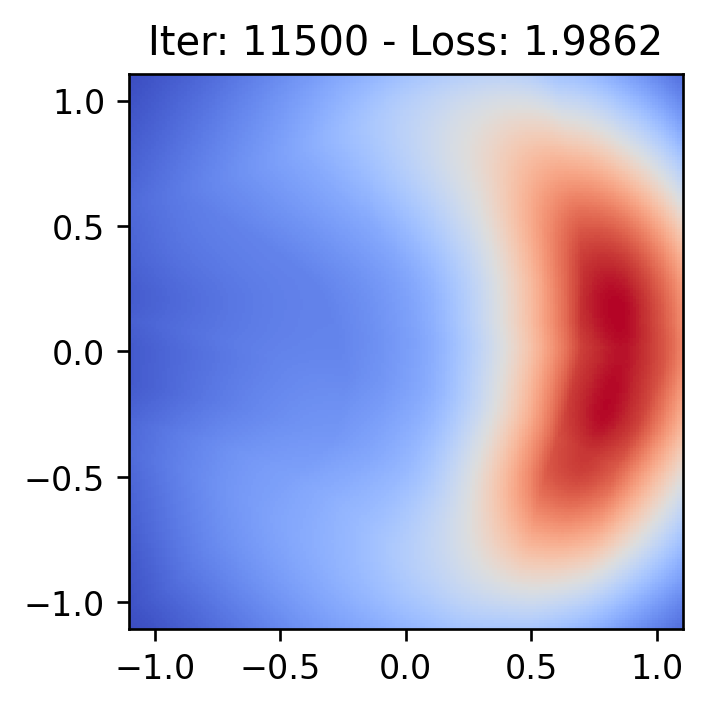

 60%|█████▉    | 11992/20000 [02:15<01:16, 104.51it/s]

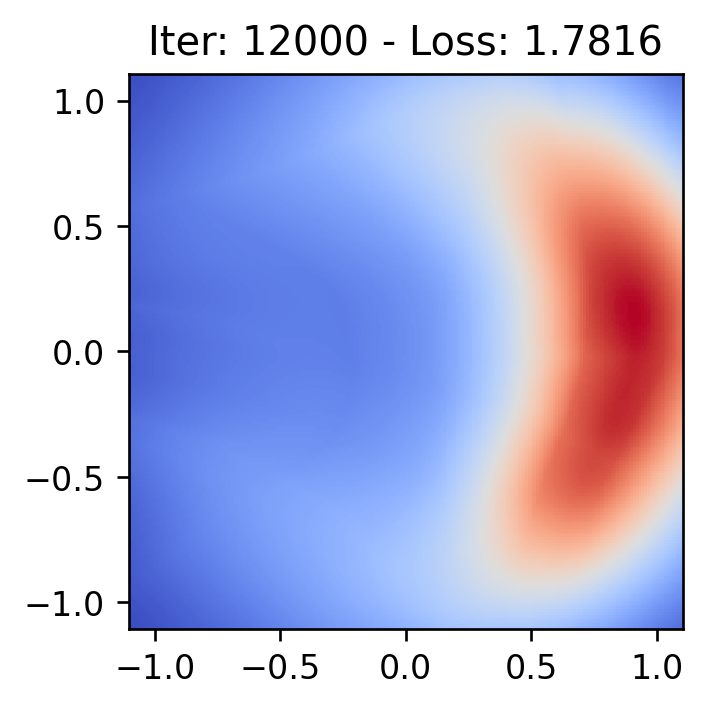

 62%|██████▏   | 12495/20000 [02:20<01:14, 100.59it/s]

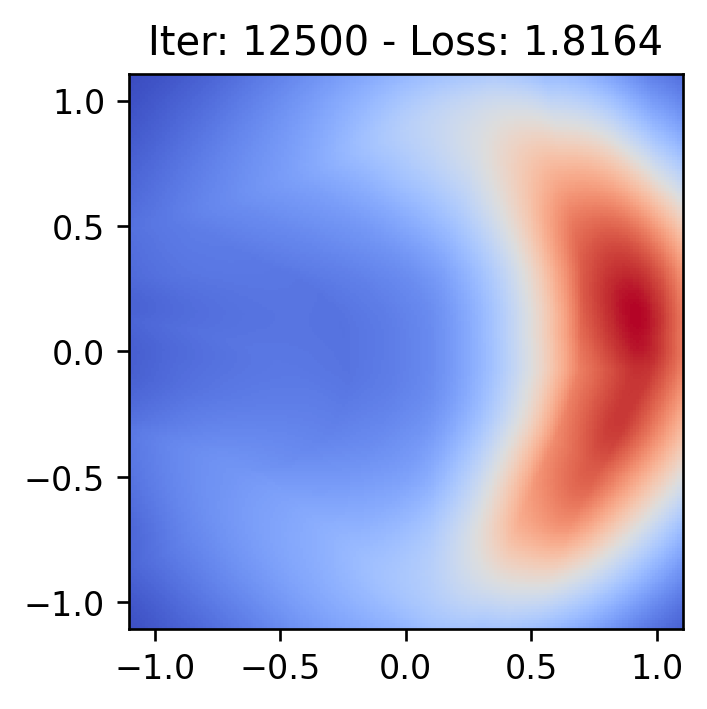

 65%|██████▍   | 12991/20000 [02:26<01:08, 102.66it/s]

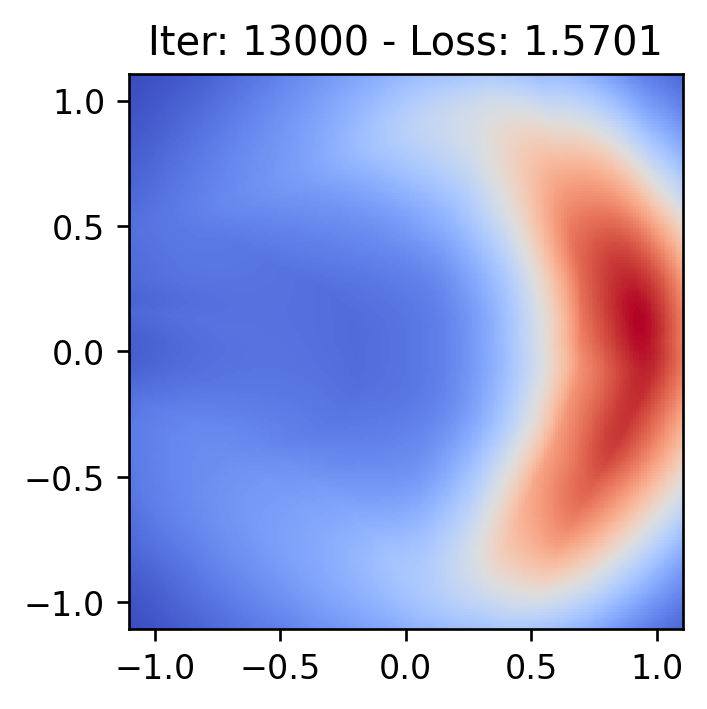

 67%|██████▋   | 13490/20000 [02:31<01:01, 105.32it/s]

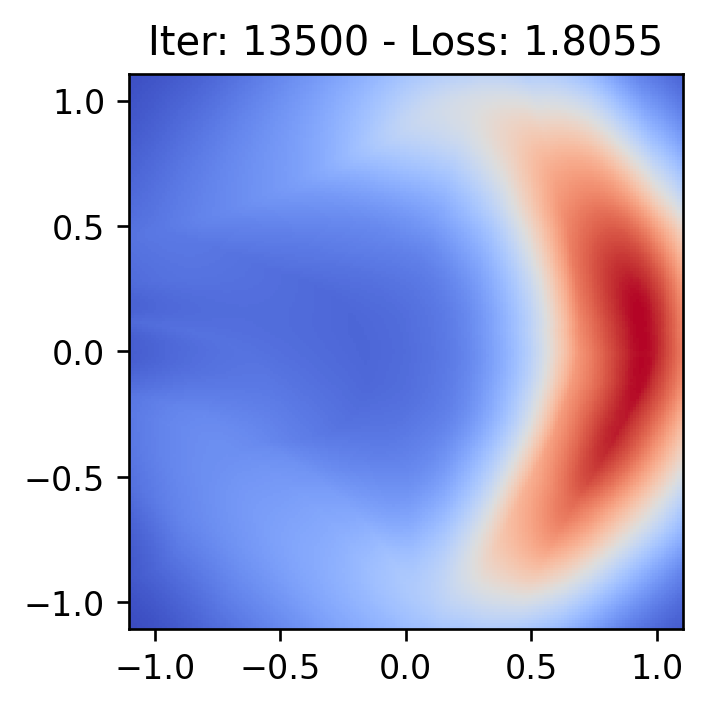

 70%|██████▉   | 13993/20000 [02:37<01:00, 98.54it/s]

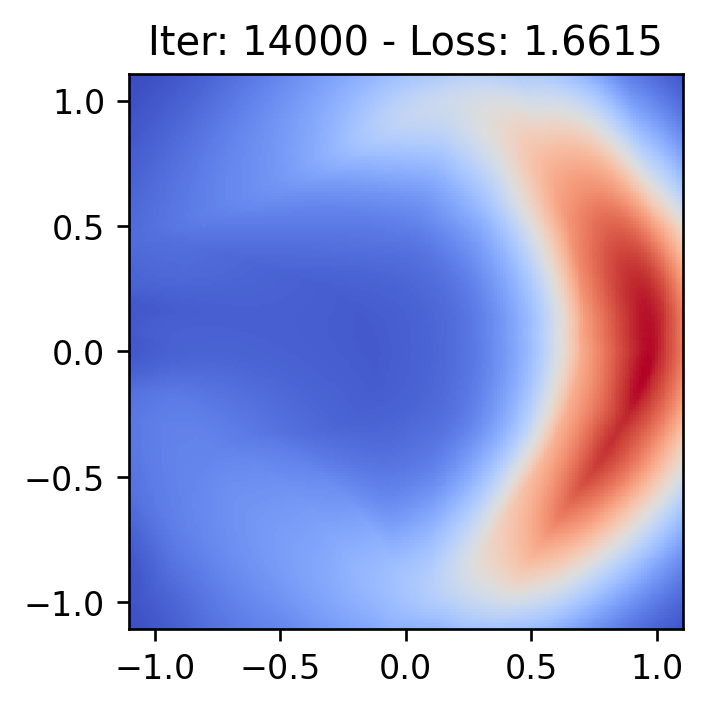

 72%|███████▏  | 14495/20000 [02:42<00:52, 105.52it/s]

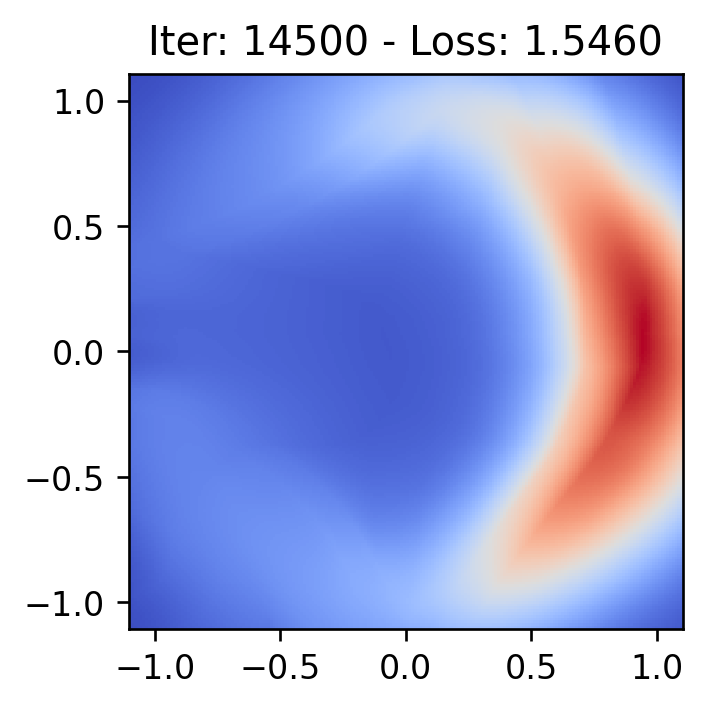

 75%|███████▍  | 14993/20000 [02:48<01:10, 71.37it/s]

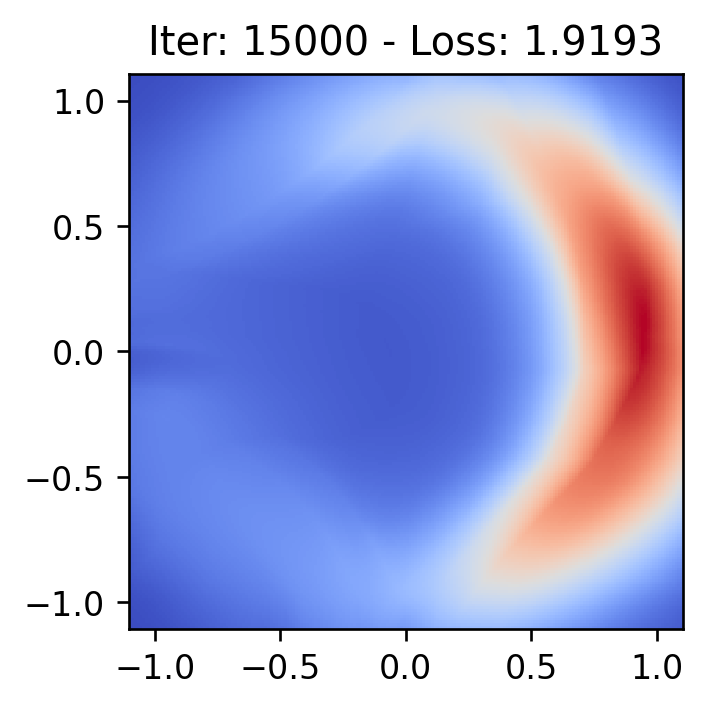

 77%|███████▋  | 15489/20000 [02:54<00:45, 99.88it/s] 

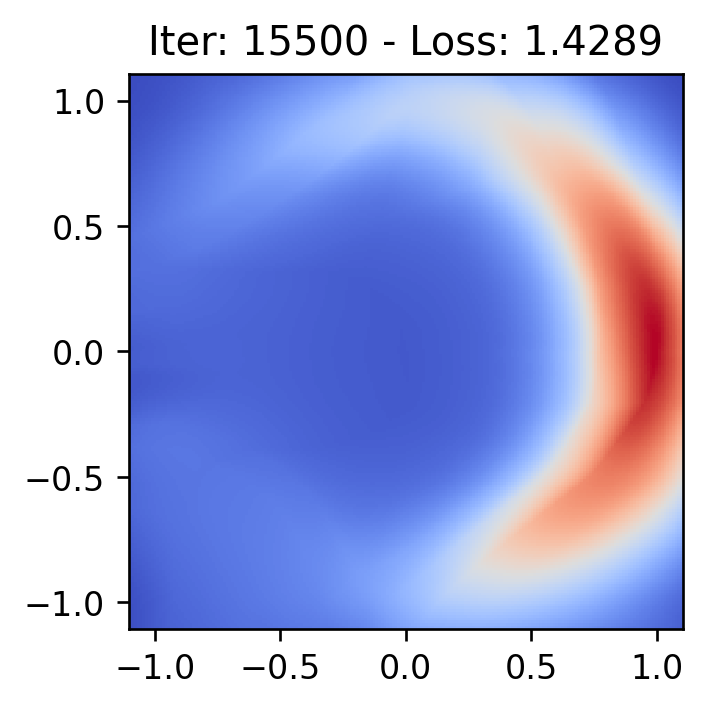

 80%|███████▉  | 15999/20000 [02:59<00:38, 105.17it/s]

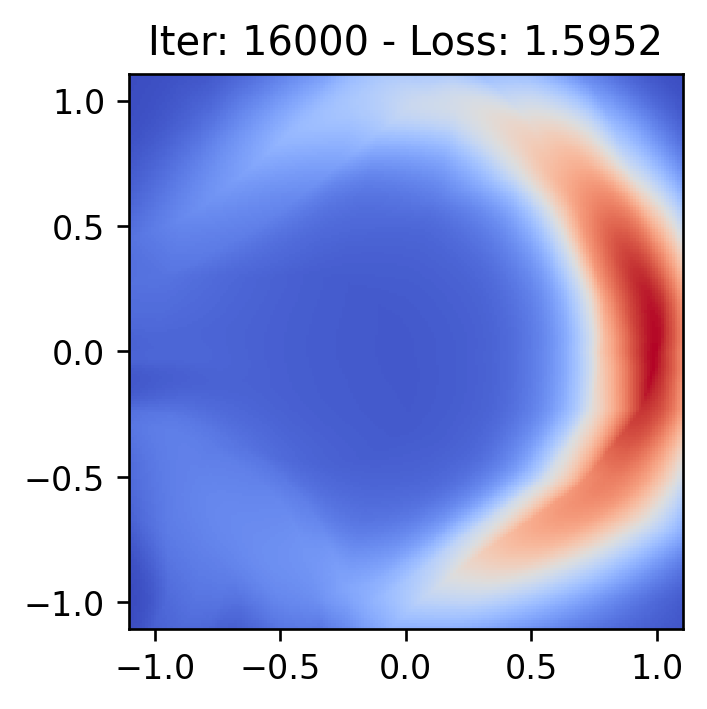

 82%|████████▏ | 16494/20000 [03:05<00:33, 105.61it/s]

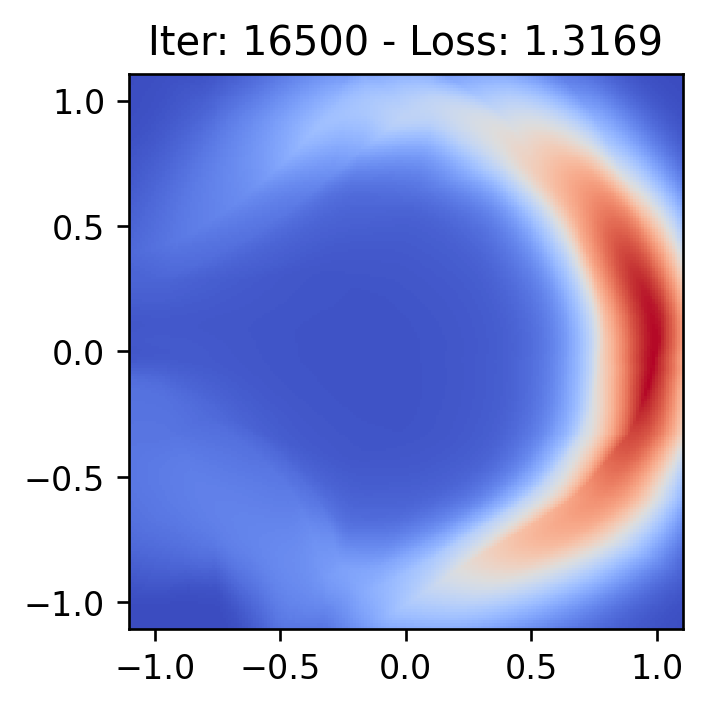

 85%|████████▍ | 16994/20000 [03:10<00:28, 103.80it/s]

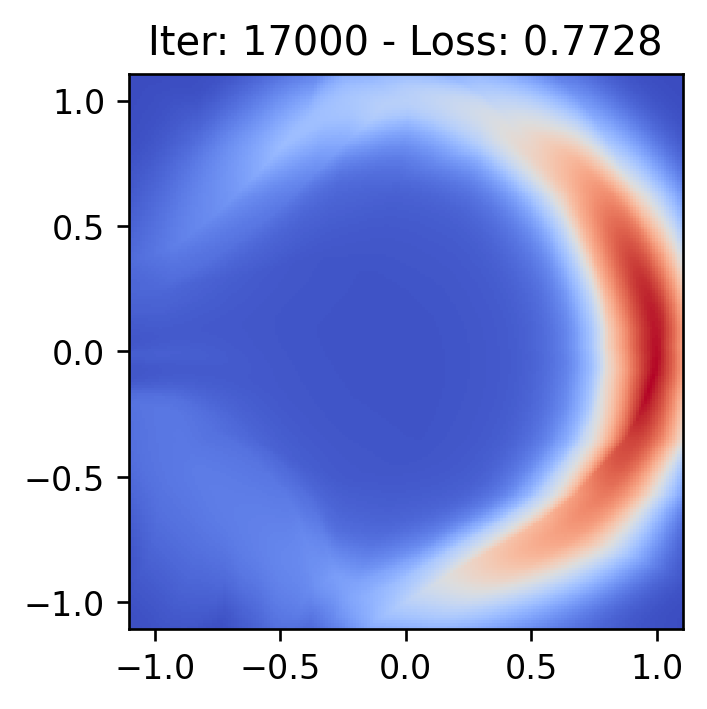

 87%|████████▋ | 17499/20000 [03:16<00:32, 76.24it/s]

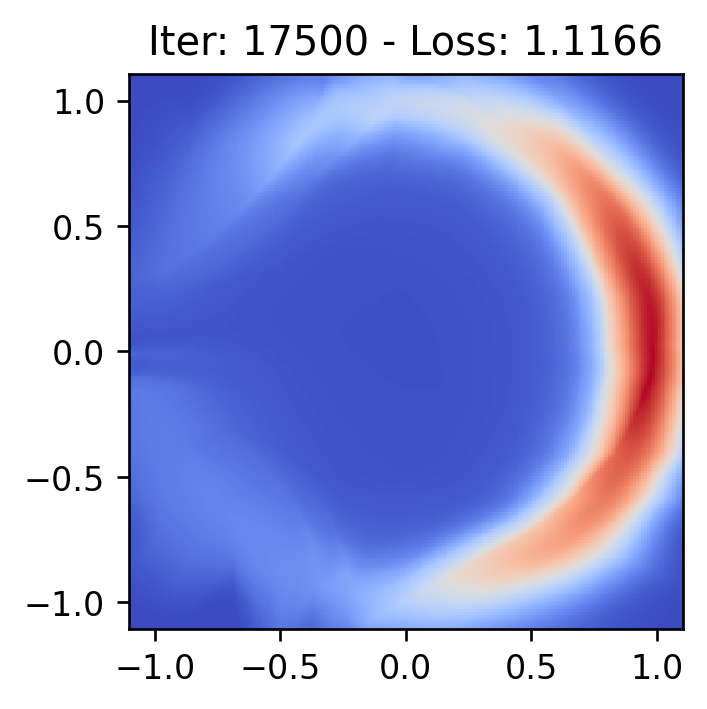

 90%|████████▉ | 17999/20000 [03:22<00:19, 100.30it/s]

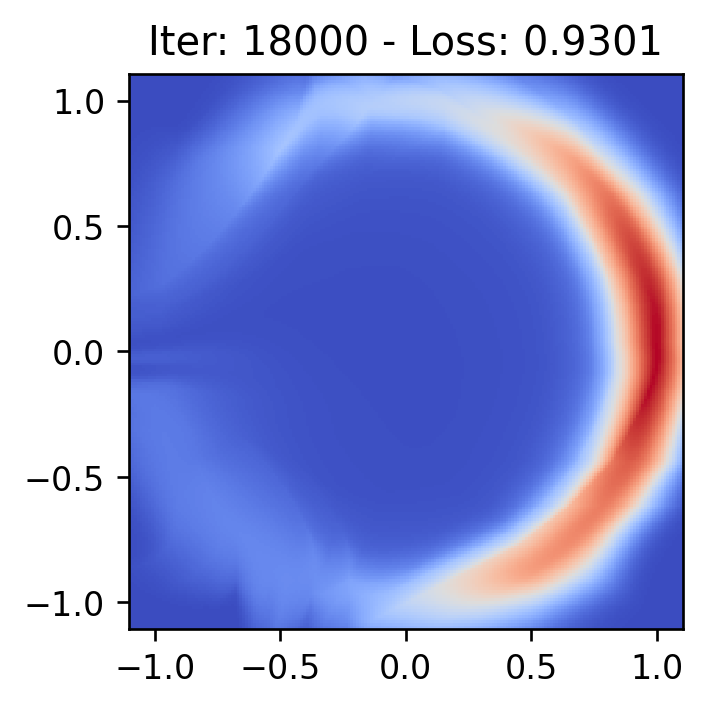

 92%|█████████▏| 18496/20000 [03:28<00:19, 75.45it/s]

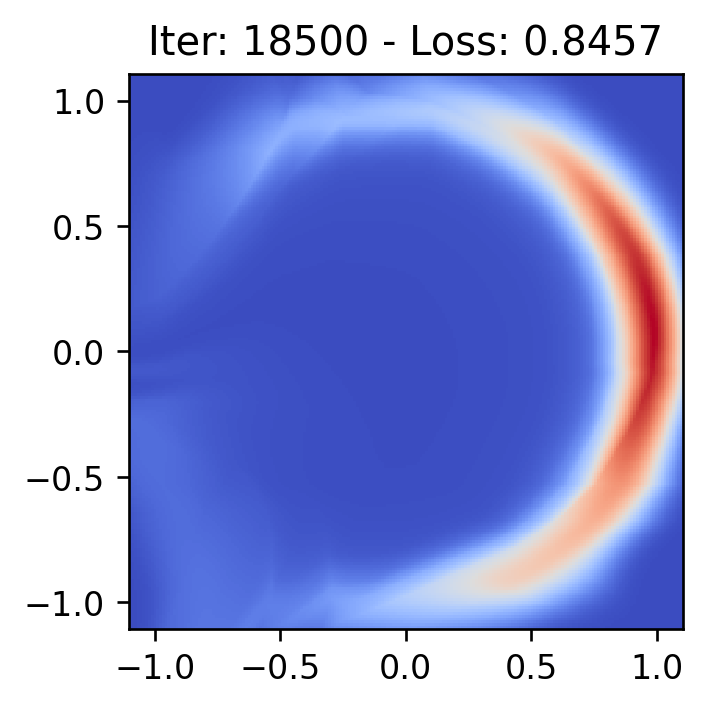

 95%|█████████▍| 18993/20000 [03:34<00:09, 101.34it/s]

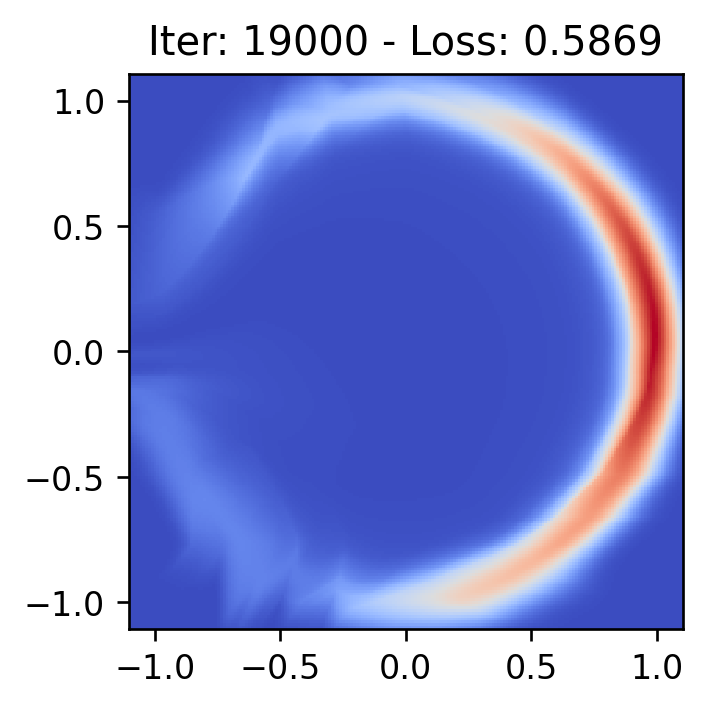

 97%|█████████▋| 19499/20000 [03:39<00:04, 101.66it/s]

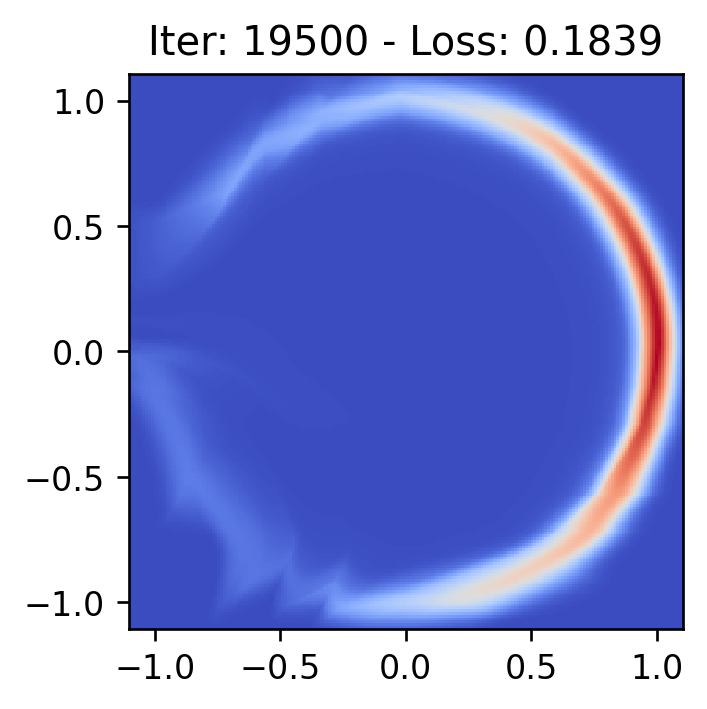

100%|█████████▉| 19994/20000 [03:45<00:00, 100.99it/s]

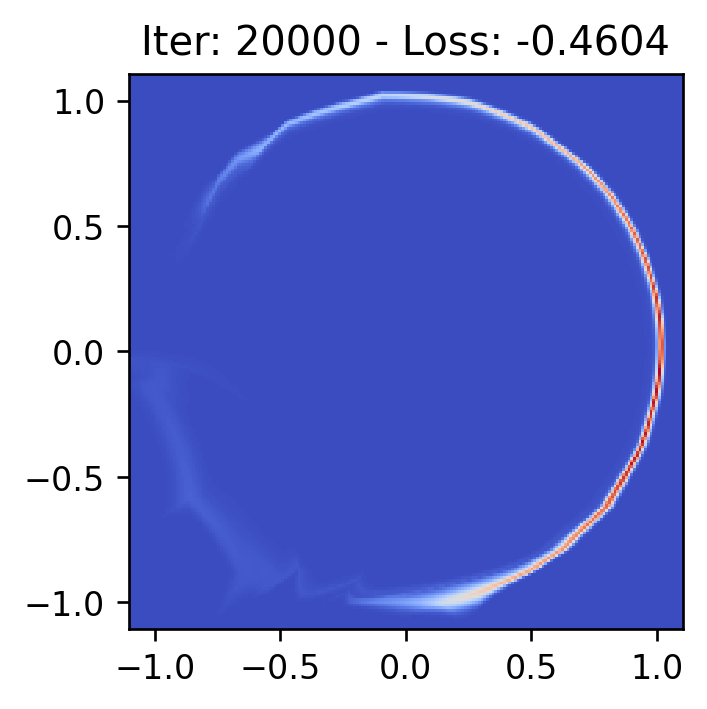

100%|██████████| 20000/20000 [03:45<00:00, 88.57it/s] 


In [ ]:
torch.manual_seed(1)

# Train model
perturbed_iter = 20000
vanilla_iter = 0
max_iter = perturbed_iter + vanilla_iter
show_iter = 500


loss_hist = np.array([])

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)

for it in tqdm(range(max_iter)):
    optimizer.zero_grad()

    try:
        x = next(train_iterator)[0]
    except StopIteration:
        train_iterator = iter(train_loader)
        x = next(train_iterator)[0]

    if it < perturbed_iter:
        noise = sigmoid_schedule(it, start=0, end=3, tau=0.7, N_max=perturbed_iter)
        x = np.sqrt(1-noise) * x + np.sqrt(noise) * torch.randn_like(x)

    # Compute loss
    loss = model.forward_kld(x)

    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer.step()

    # Log loss
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())


    # Plot learned distribution
    if (it + 1) % show_iter == 0:
        model.eval()
        log_prob = model.log_prob(zz)
        model.train()
        prob = torch.exp(log_prob.to('cpu').view(*xx.shape))
        prob[torch.isnan(prob)] = 0

        plt.figure(figsize=(3, 3), dpi=240)
        plt.pcolormesh(xx, yy, prob.data.numpy(), cmap='coolwarm')

        plt.gca().set_aspect('equal', 'box')
        plt.title("Iter: {} - Loss: {:.4f}".format(it+1, loss))
        plt.show()


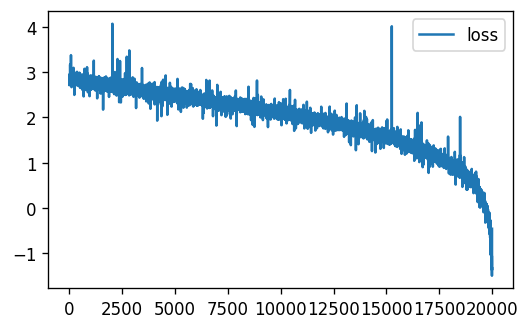

In [ ]:
# Plot loss
plt.figure(figsize=(5, 3), dpi=120)
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()